In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor

In [2]:
df = pd.read_pickle('../data/interim/resampled_data.pkl')
df.head()

acc_x     acc_y     acc_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   

                        participant  label category  set  
epoch (ms)                                                
2019-01-11 15:08:05.200           B  bench    heavy   30  
2019-01-11 15:08:05.400           B  bench    heavy   30  
2019-01-11 15:08:05.600           B  bench    heavy   30  
2019-01-11 15:08:05.800           B  bench    heavy   30  
2019-01-11 15:08:06.000           B  bench    heavy   30

In [3]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

<Axes: title={'center': 'acc_x'}, xlabel='[label]'>

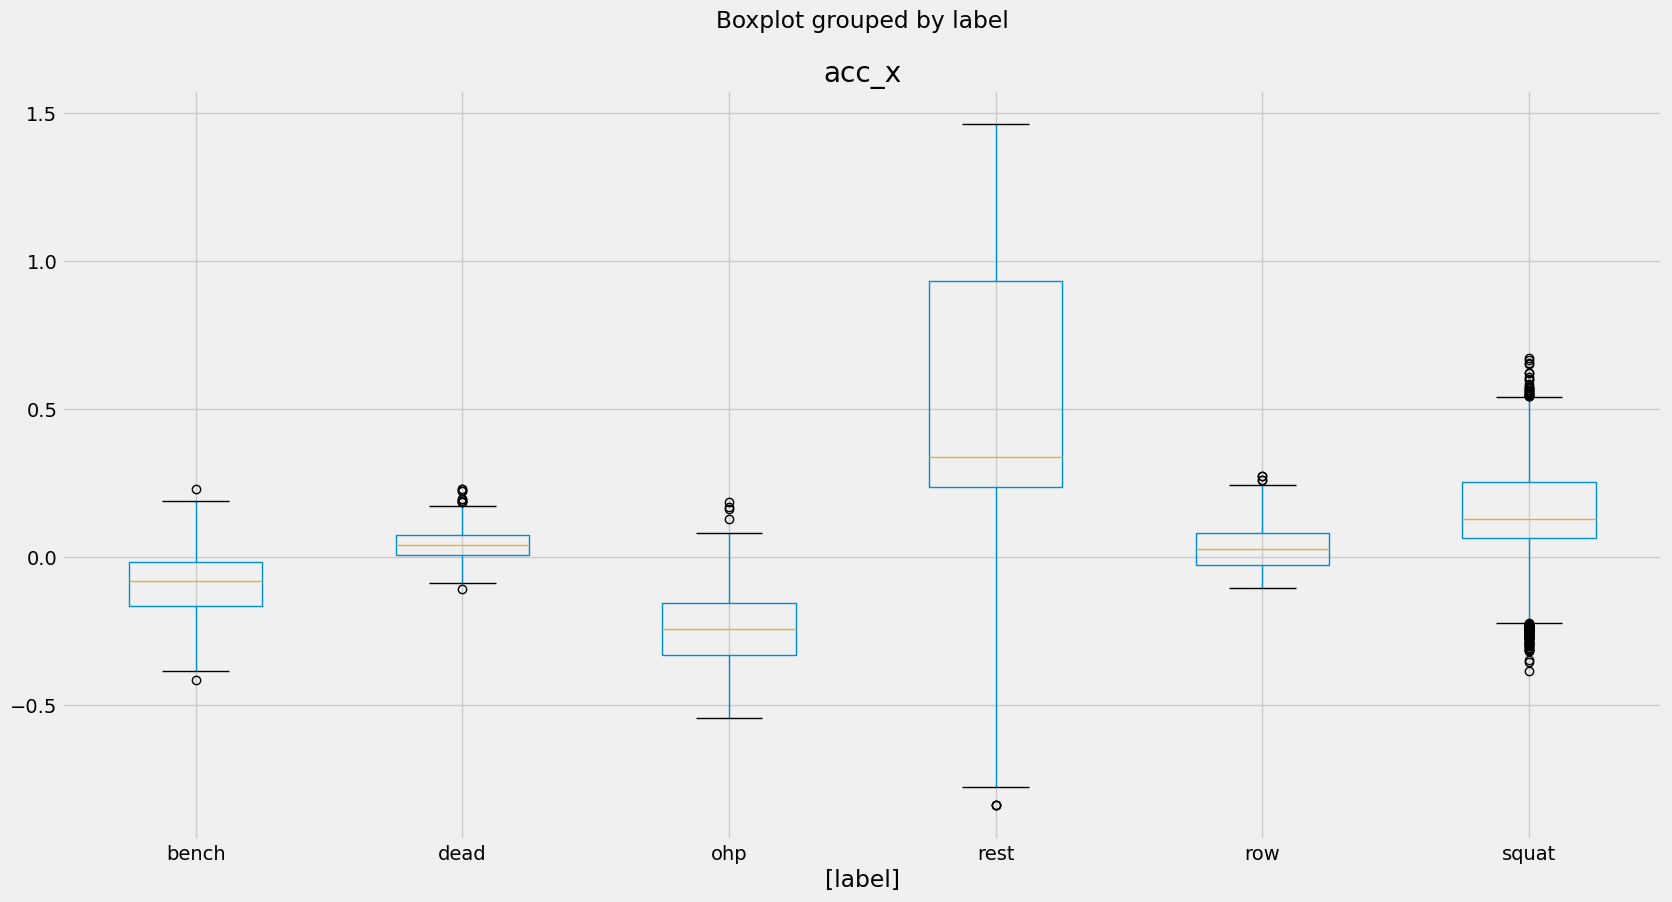

In [4]:
# Creating boxplot

df[["acc_x", "label"]].boxplot(by="label", figsize=(20,10))

<Axes: title={'center': 'acc_y'}, xlabel='[label]'>

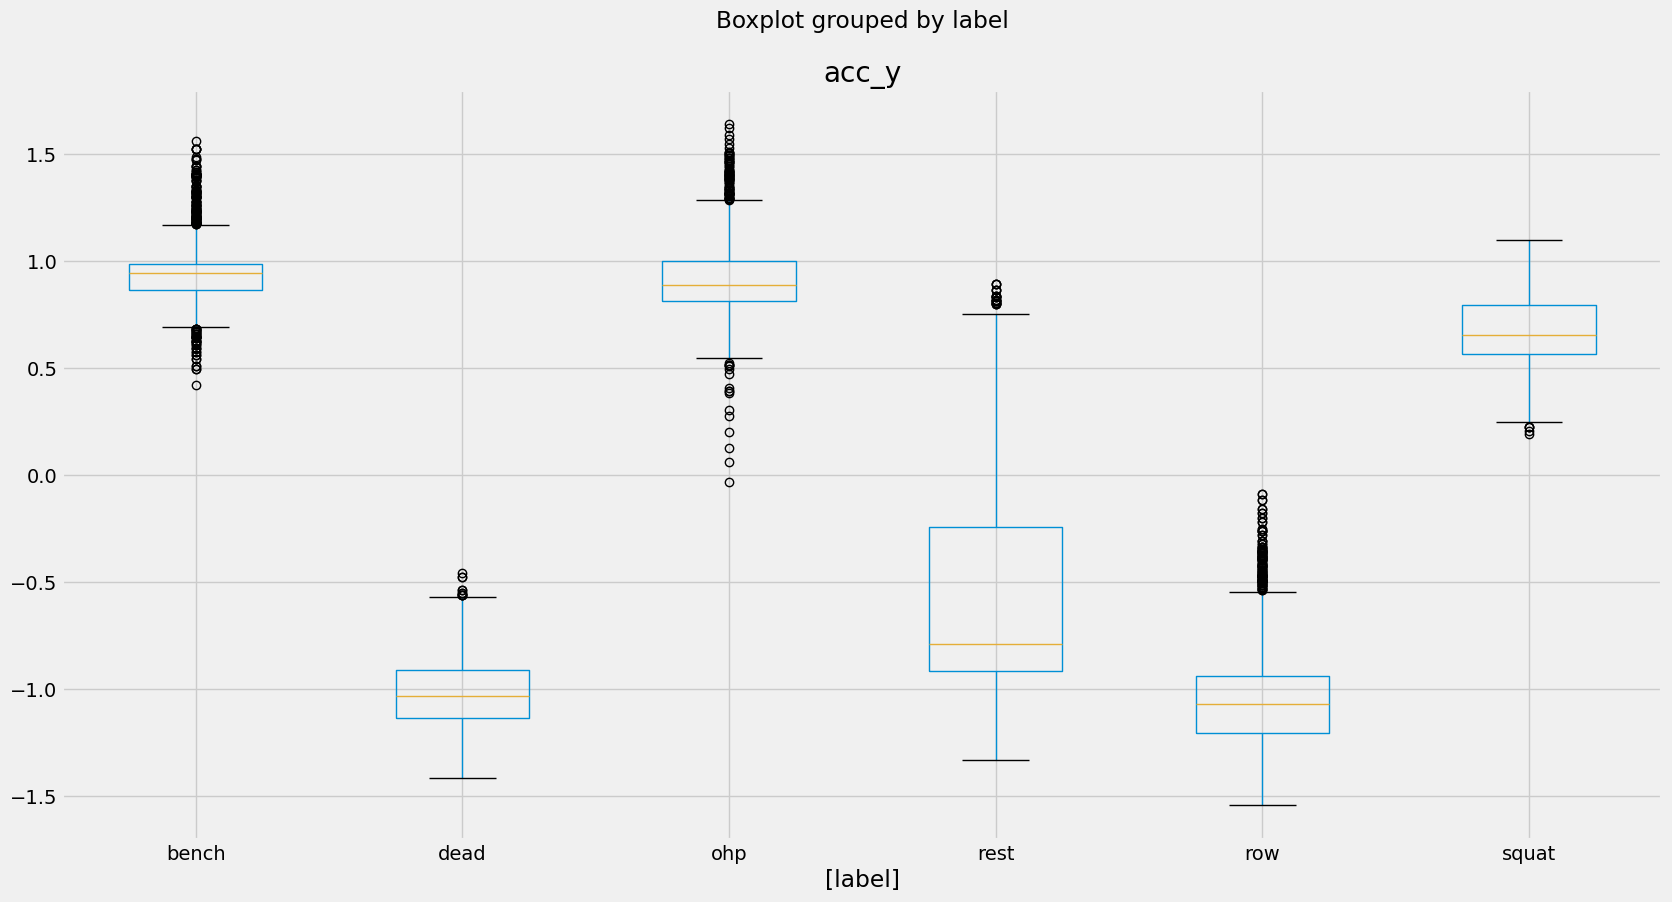

In [5]:
df[["acc_y", "label"]].boxplot(by="label", figsize=(20,10))

<Axes: title={'center': 'gyro_y'}, xlabel='[label]'>

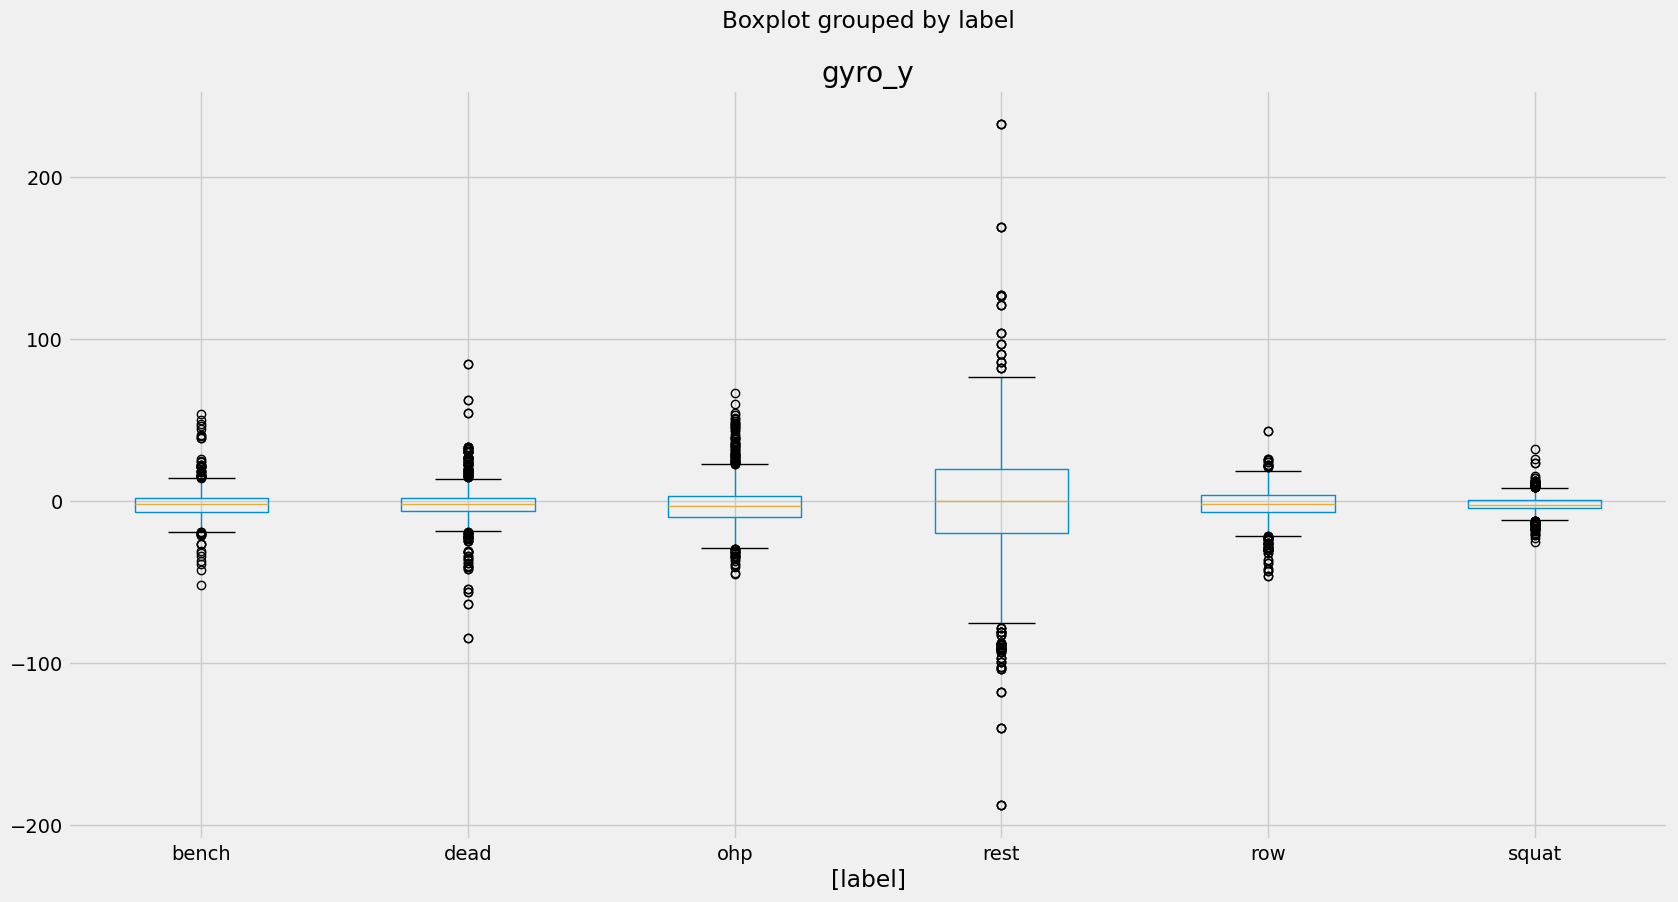

In [6]:
df[["gyro_y", "label"]].boxplot(by="label", figsize=(20,10))

In [7]:
outlier_columns = list(df.columns[:6])
outlier_columns

['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

In [8]:
df[outlier_columns[:3] + ["label"]]

acc_x     acc_y     acc_z  label
epoch (ms)                                                  
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000  bench
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500  bench
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  bench
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  bench
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  bench
...                           ...       ...       ...    ...
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500    row
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333    row
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000    row
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667    row
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000    row

[9009 rows x 4 columns]

array([<Axes: title={'center': 'acc_x'}, xlabel='[label]'>,
       <Axes: title={'center': 'acc_y'}, xlabel='[label]'>,
       <Axes: title={'center': 'acc_z'}, xlabel='[label]'>], dtype=object)

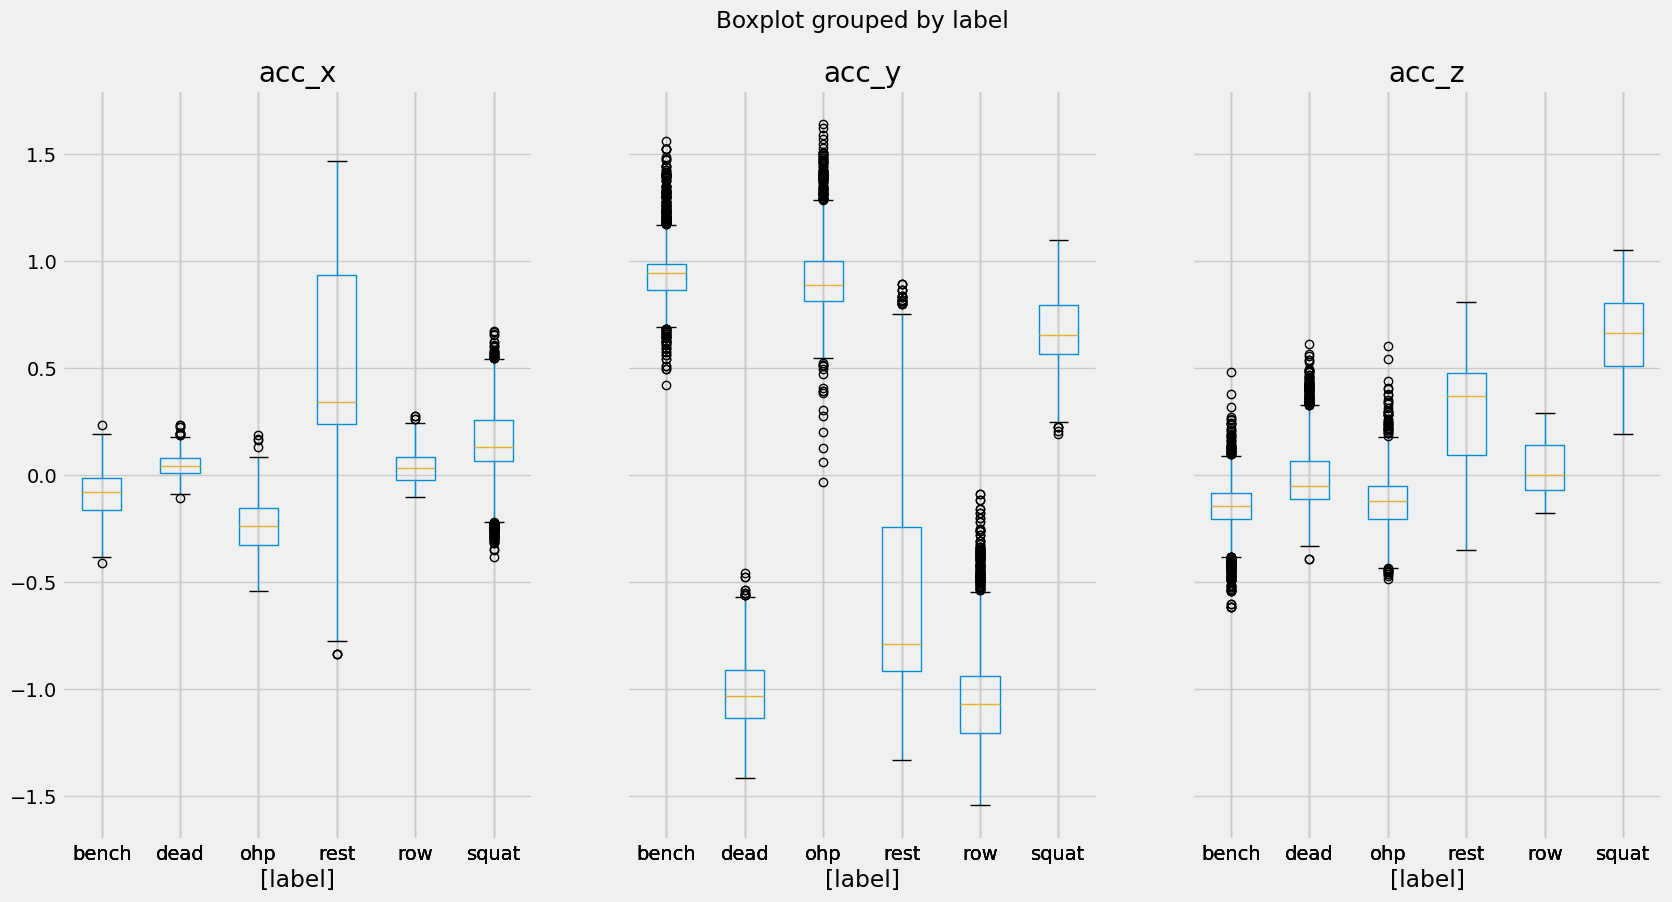

In [9]:
# Accelerometer data boxplot

df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20,10), layout=(1,3))

array([<Axes: title={'center': 'gyro_x'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyro_y'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyro_z'}, xlabel='[label]'>], dtype=object)

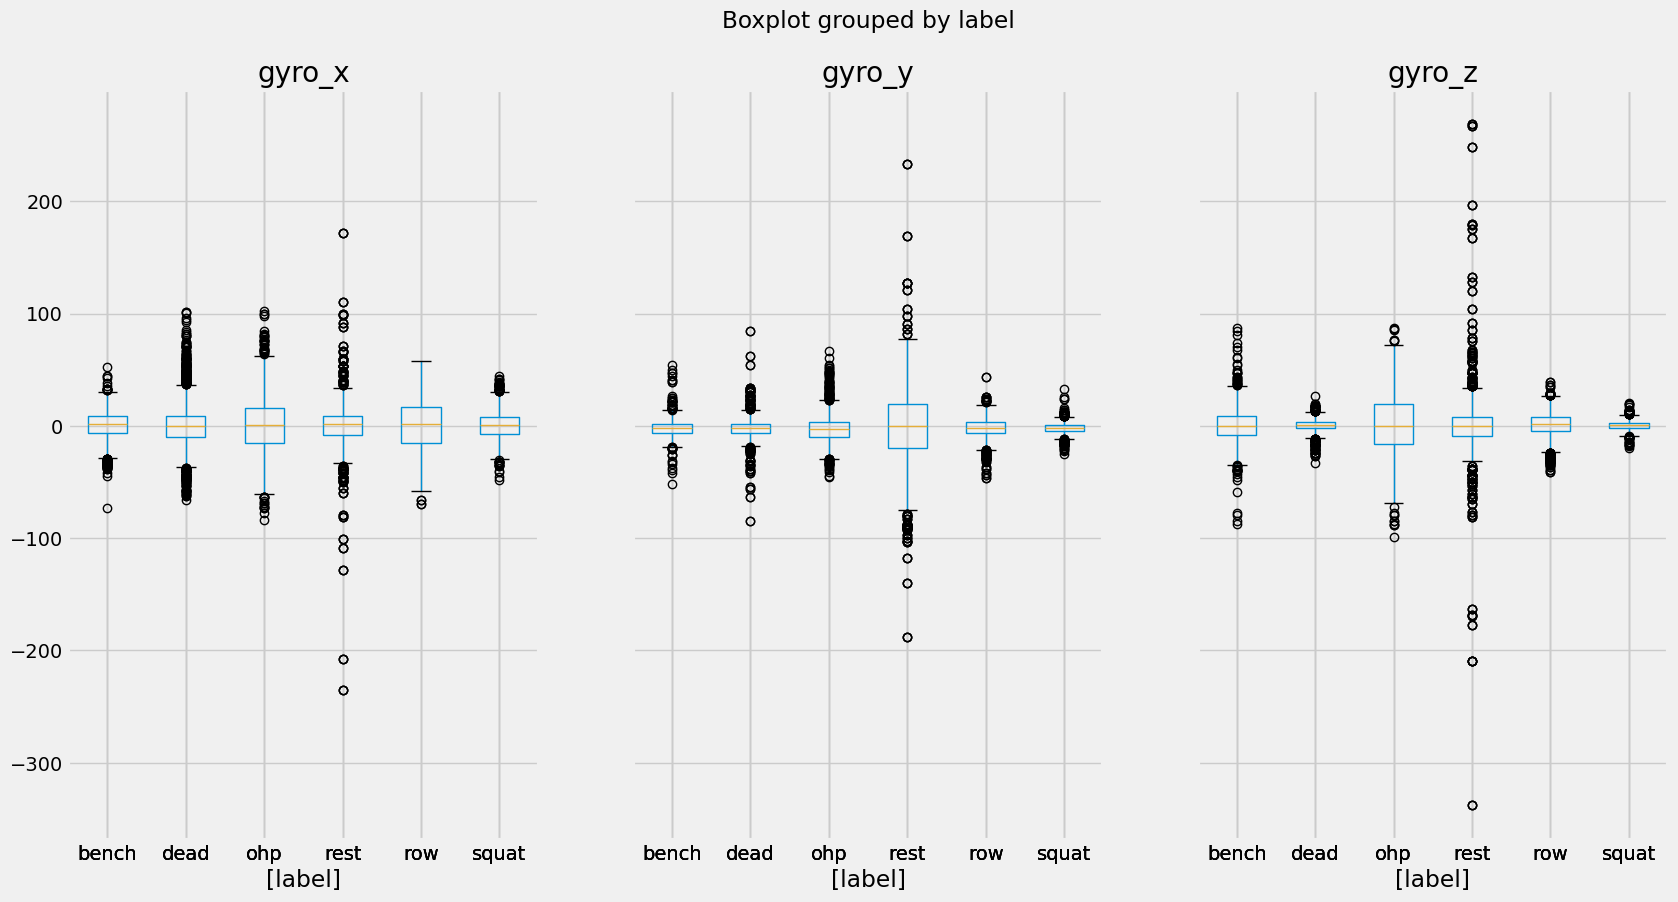

In [10]:
# Gryoscope data plotting

df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20,10), layout=(1,3))

In [11]:
# A function to mark whether the data points are outliers or not.
# Function to mark values as outliers using the IQR(Interquartile range) method.

def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

In [32]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """
    

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["no outlier " + col, "outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [13]:
col = "acc_x"
dataset = mark_outliers_iqr(df, col)
dataset

acc_x     acc_y     acc_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  acc_x_outlier  
epoch (ms)                                                               
2019-01-11 15:08:05.200           B  bench    heavy   30          False  
2019-01-11 15:08:05.400           B  bench    heavy   30          False  
2019-01-11 15:08:05.600           B  bench    heavy   30          False  
2019-01-11 15:08:05.800           B  bench    heavy   30          False  
2019-01-11 15:08:06.000           B  bench    heavy   30          False  
...                             ...    ...      ...  ...            ...  
2019-01-20 17:33:27.000           E    row   medium   90          False  
2019-01-20 17:33:27.200           E    row   medium   90          False  
2019-01-20 17:33:27.400           E    row   medium   90          False  
2019-01-20 17:33:27.600           E    row   medium   90          False  
2019-01-20 17:33:27.800           E    row   medium   90          False  

[9009 rows x 11 columns]

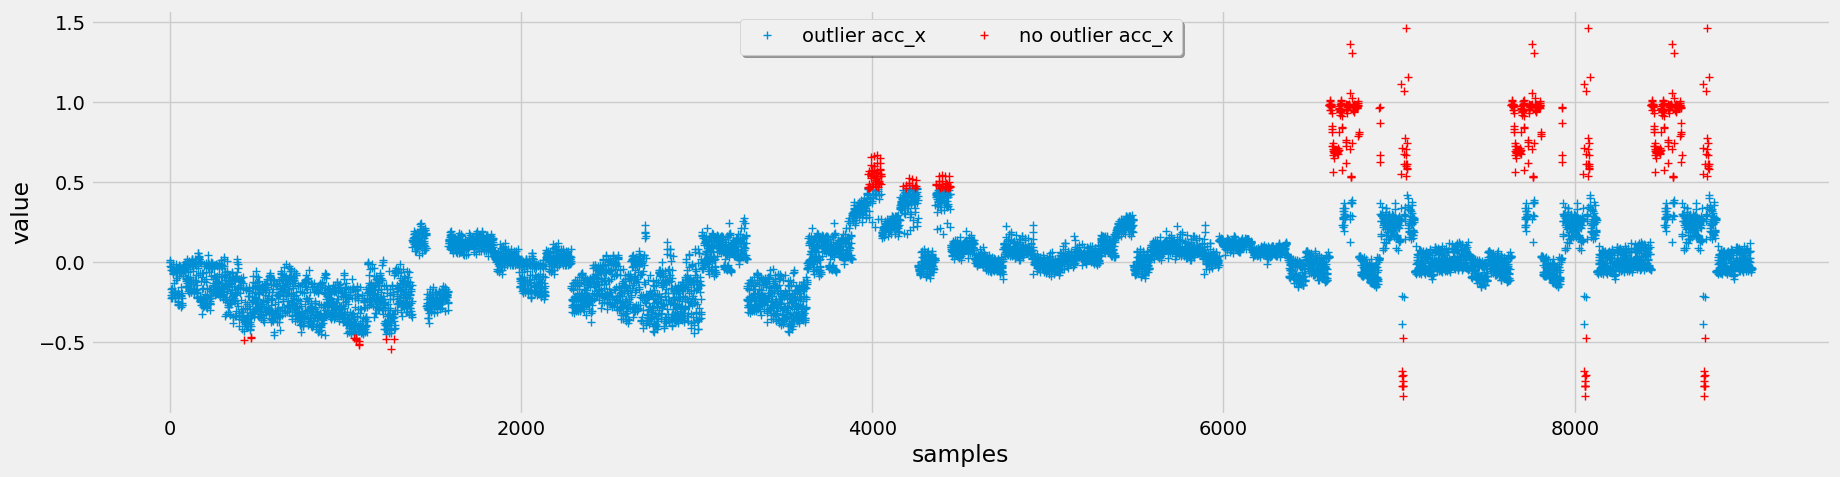

In [14]:
plot_binary_outliers(dataset = dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

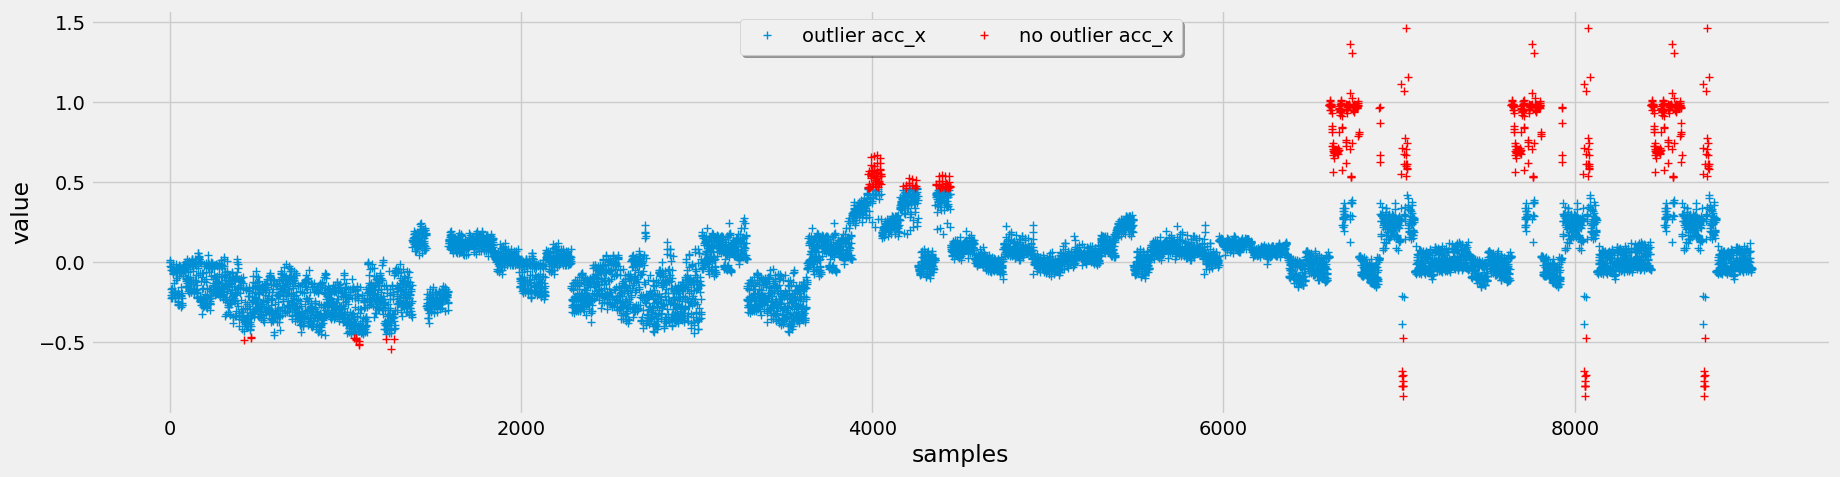

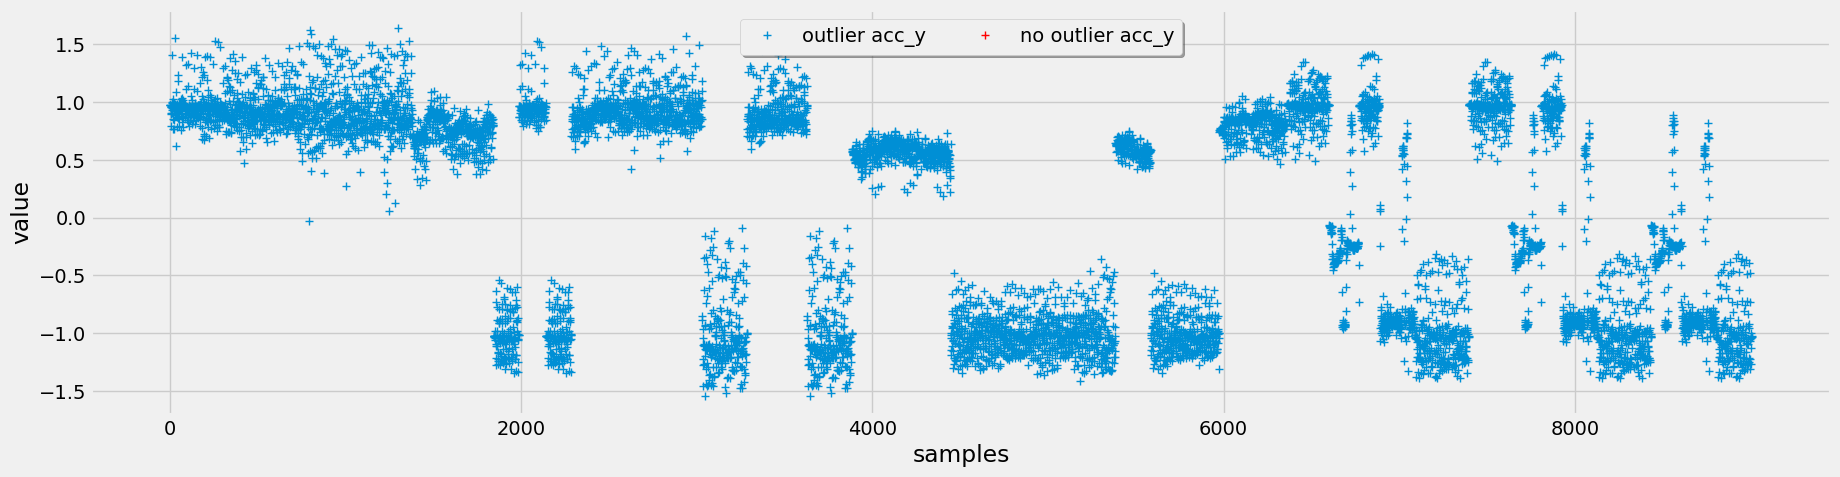

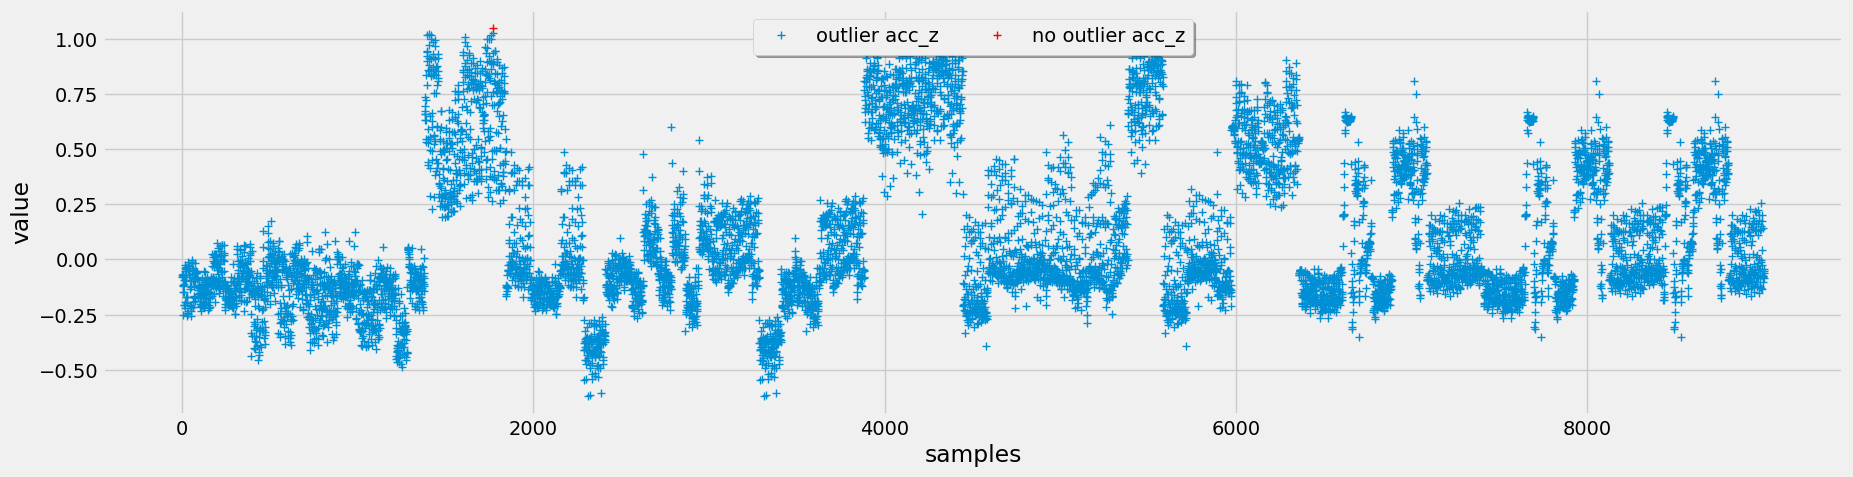

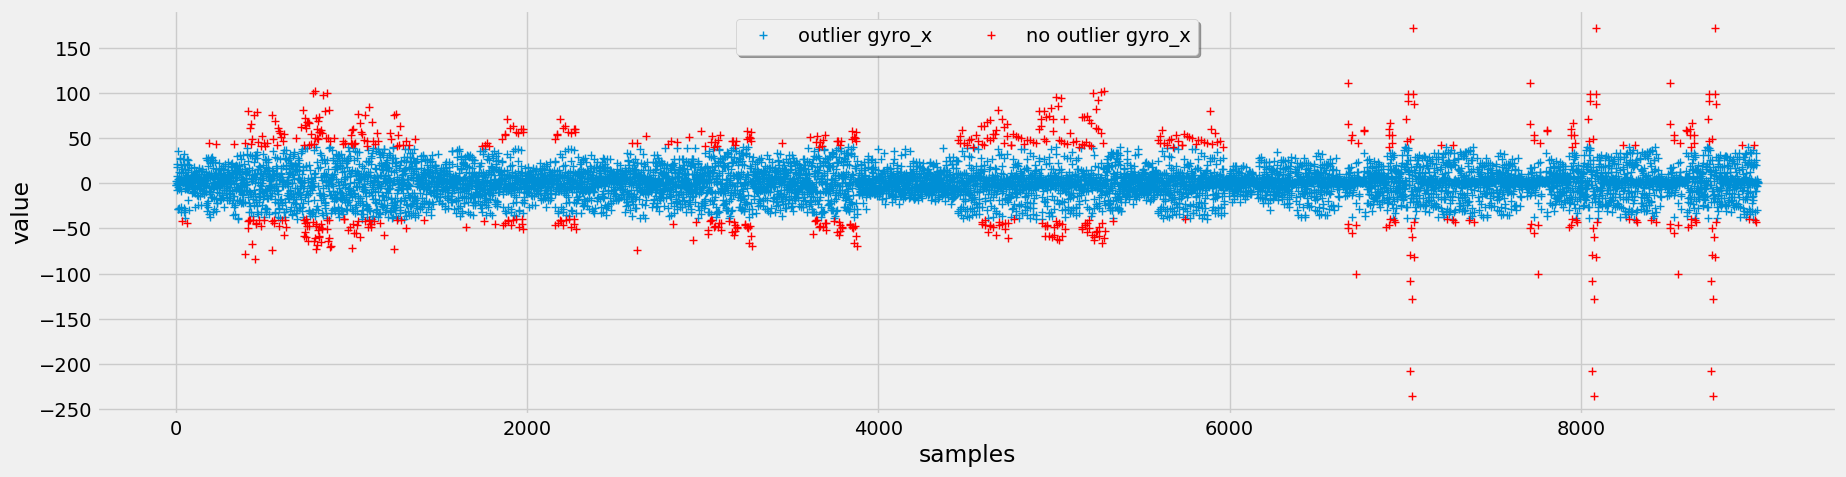

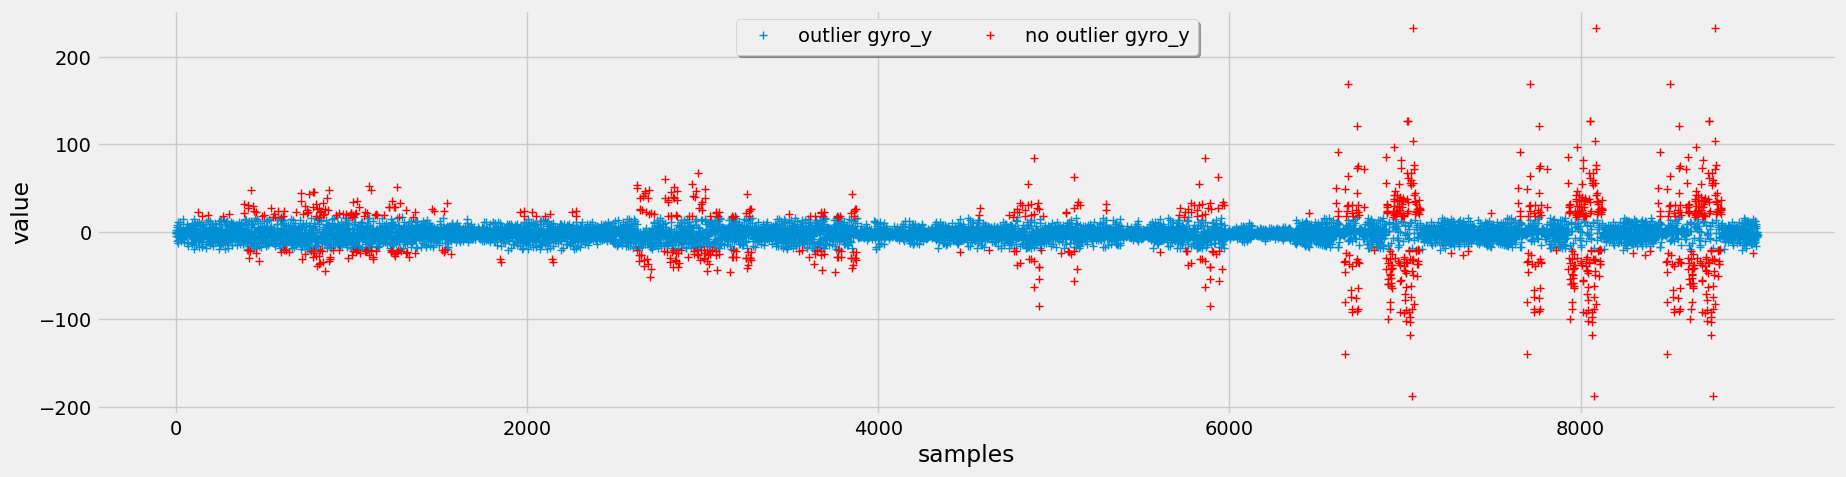

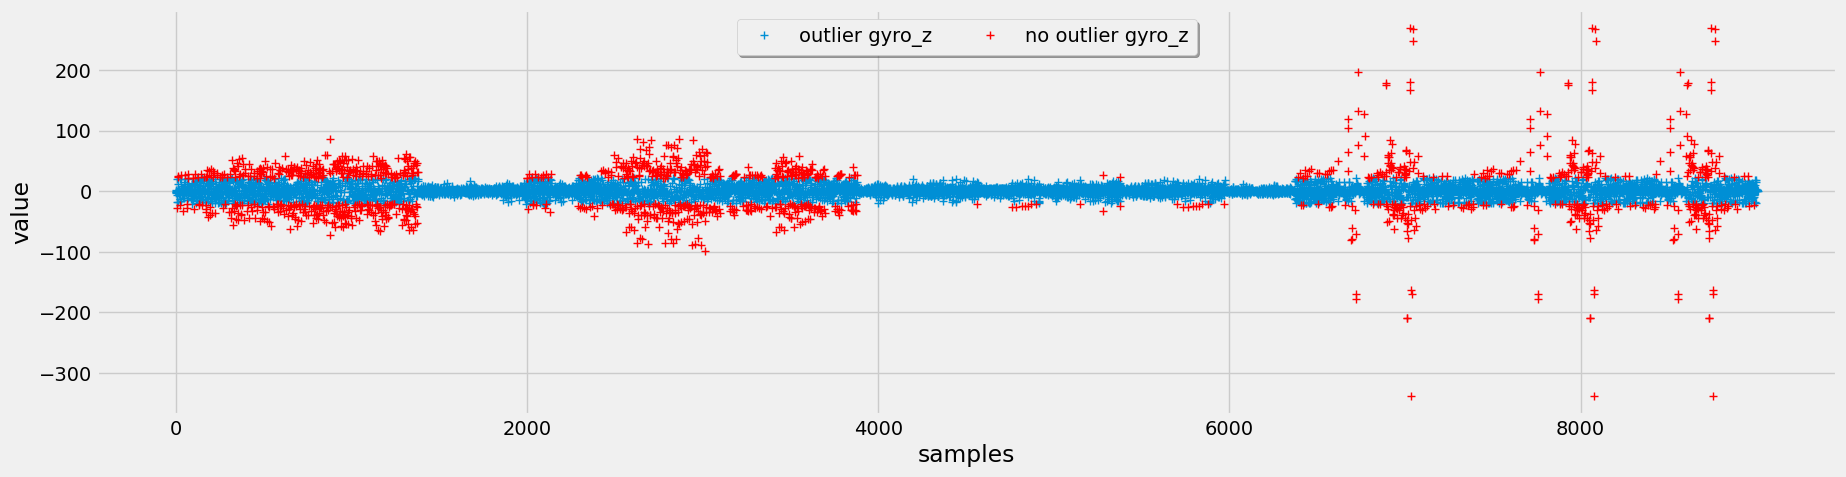

In [15]:
for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(dataset = dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

### Chauvenets criterion (Distrubition based)

array([[<Axes: title={'center': 'bench'}, ylabel='Frequency'>,
        <Axes: title={'center': 'dead'}, ylabel='Frequency'>,
        <Axes: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<Axes: title={'center': 'rest'}, ylabel='Frequency'>,
        <Axes: title={'center': 'row'}, ylabel='Frequency'>,
        <Axes: title={'center': 'squat'}, ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

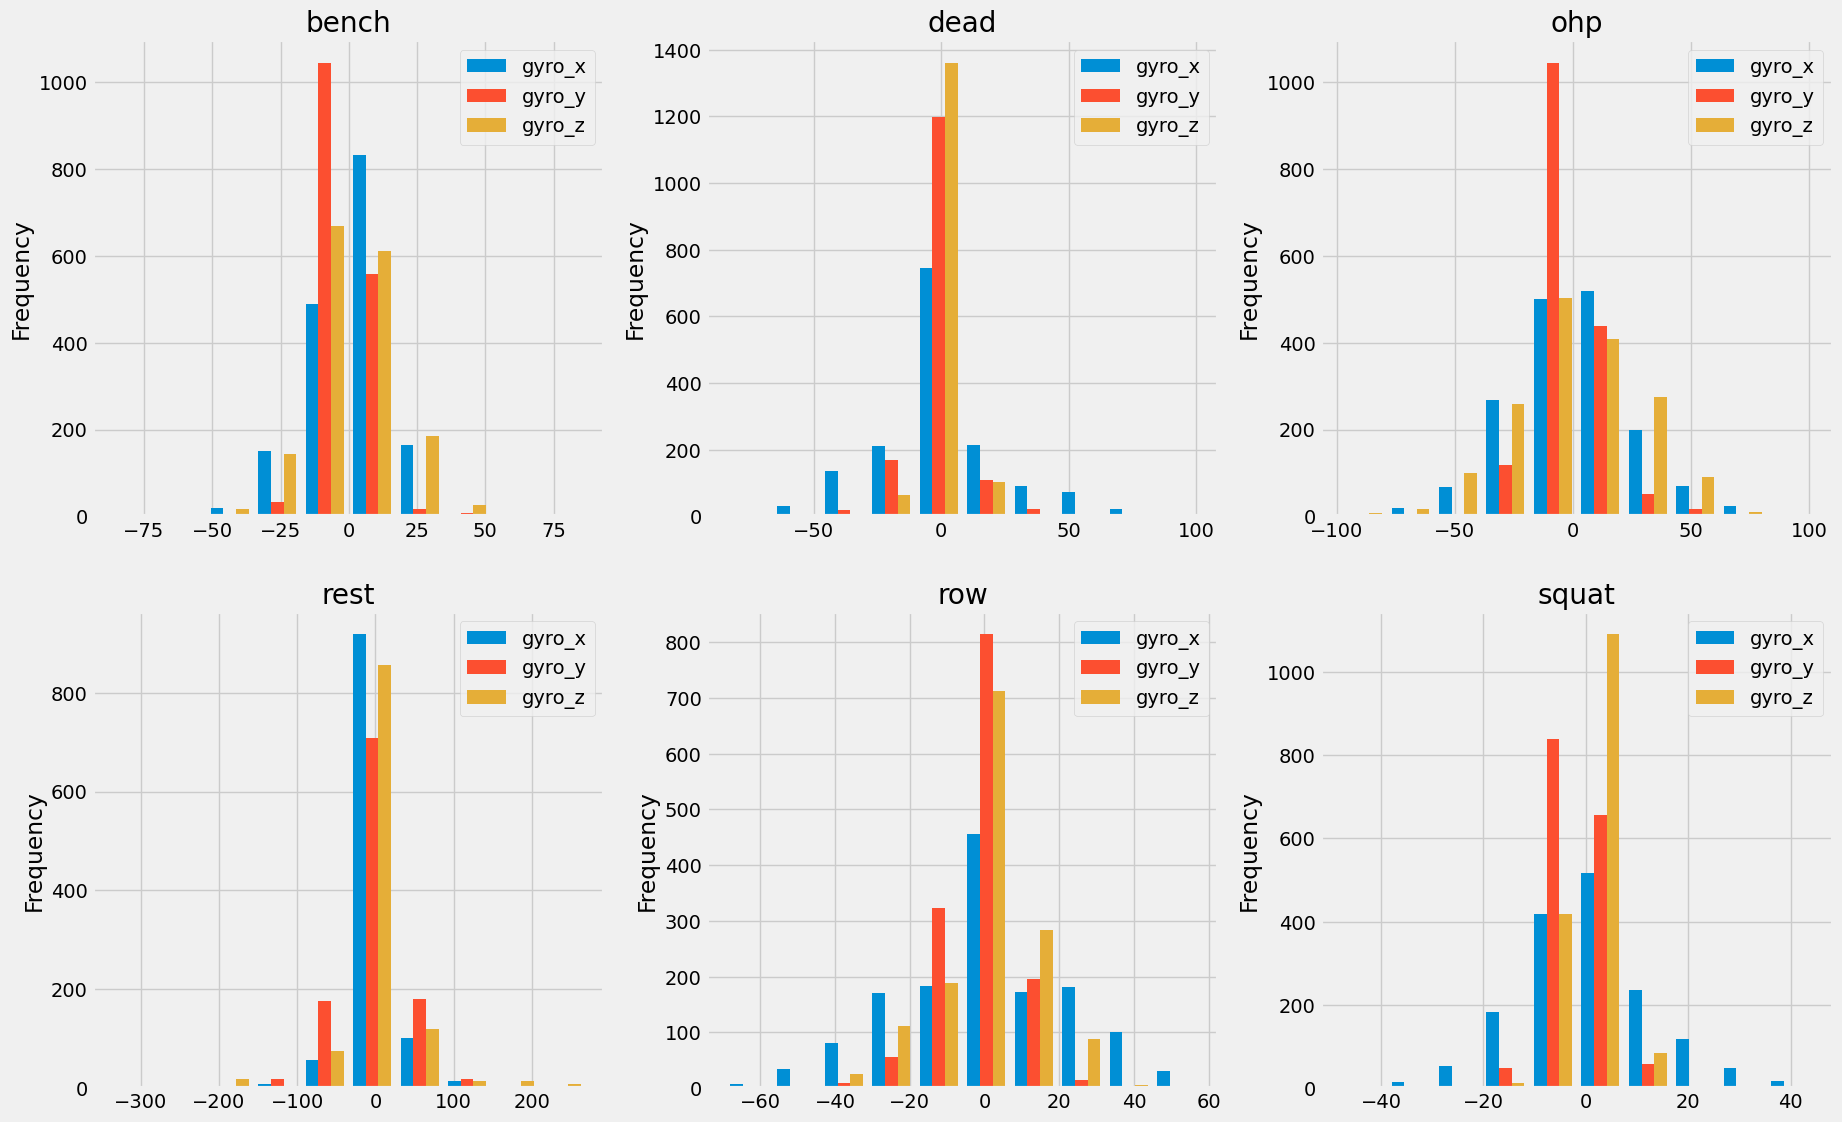

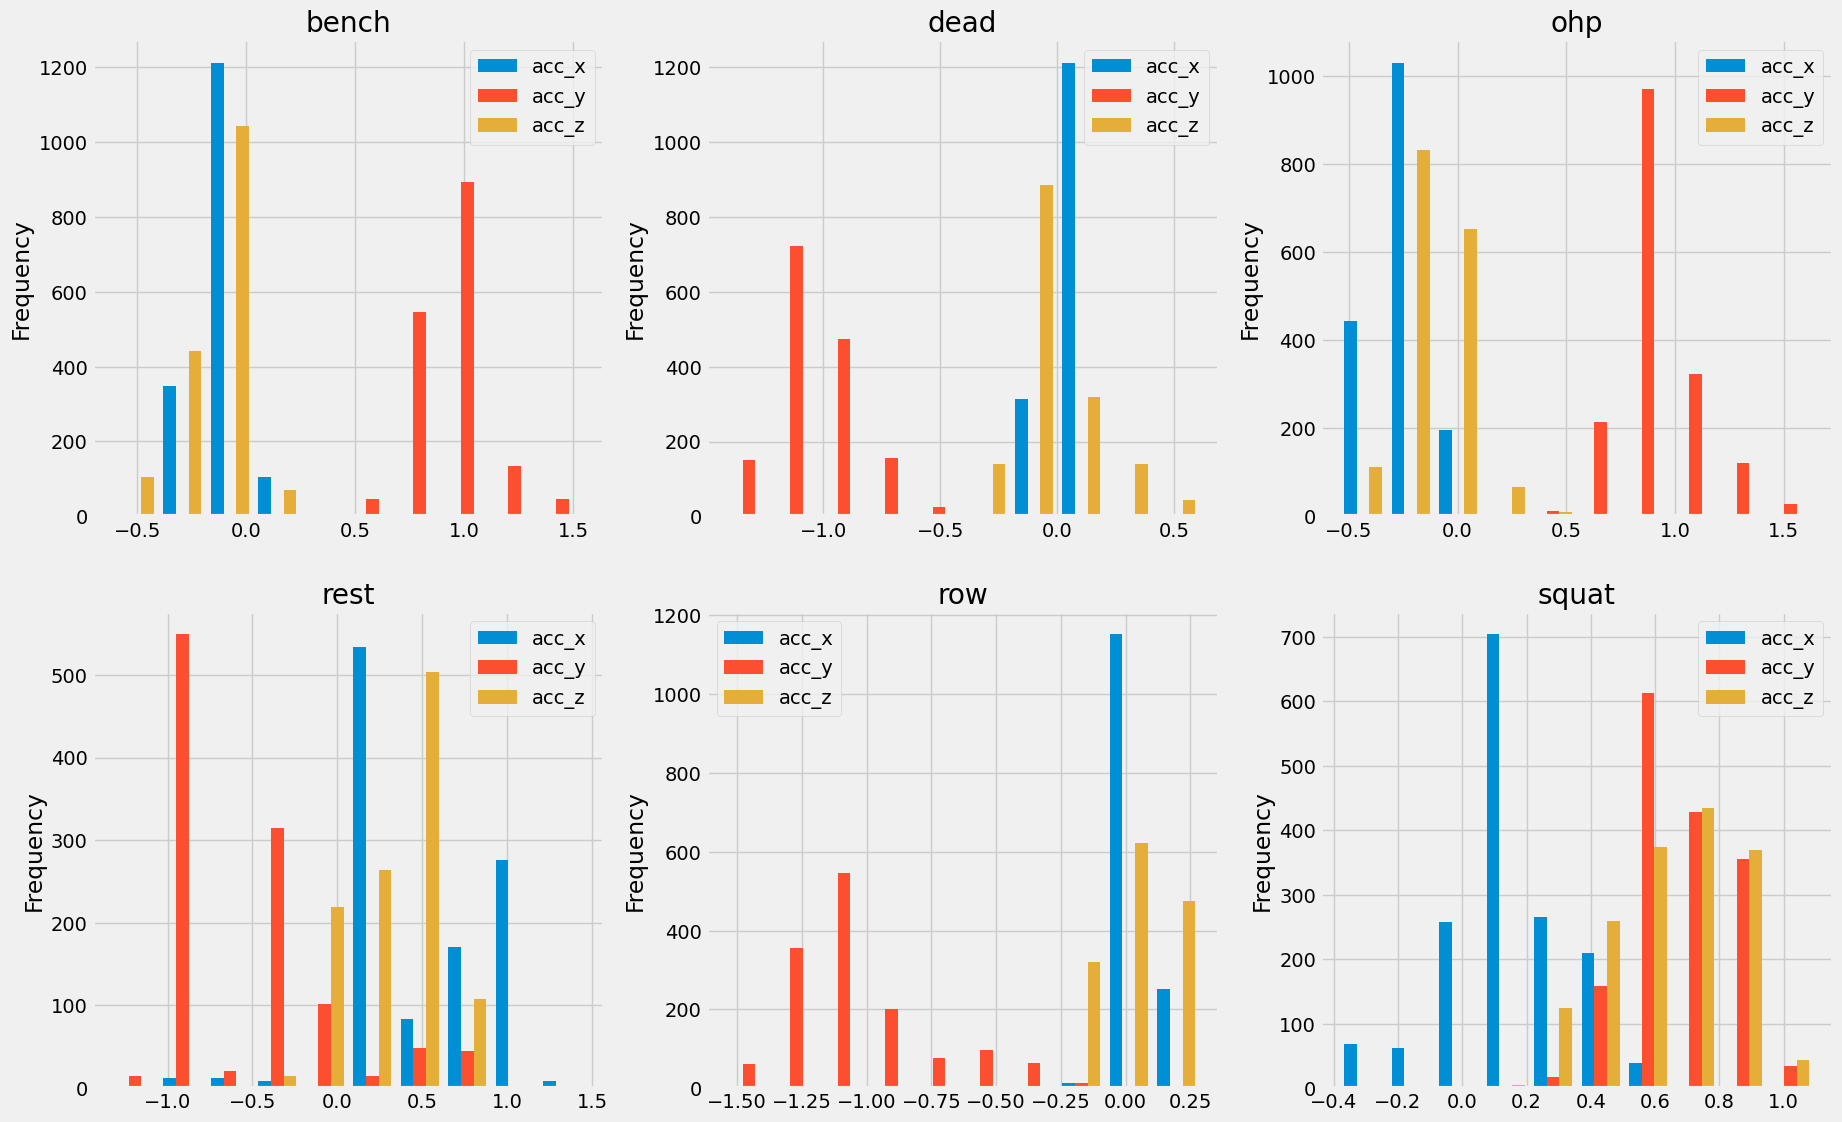

In [16]:
# Ensuring Normal Distribution

df[outlier_columns[3:] + ["label"]].plot.hist(by="label", figsize=(20,20), layout=(3,3))
df[outlier_columns[:3] + ["label"]].plot.hist(by="label", figsize=(20,20), layout=(3,3))

In [17]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


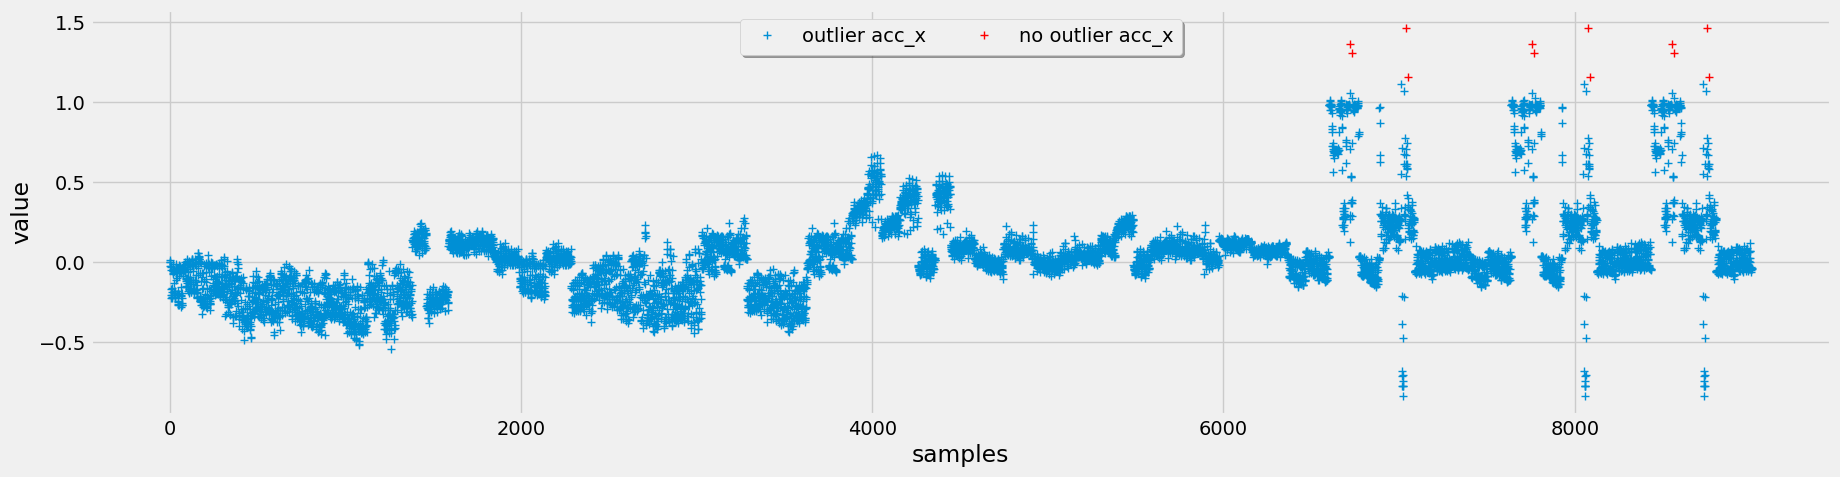

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


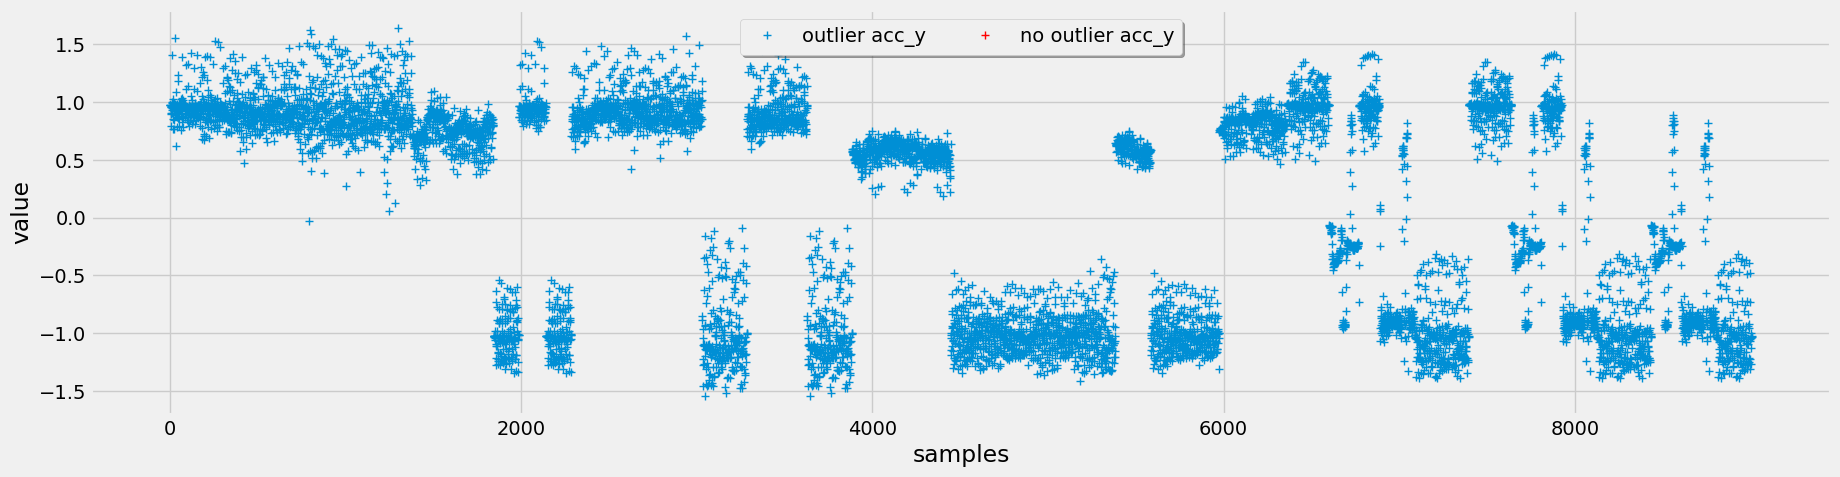

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


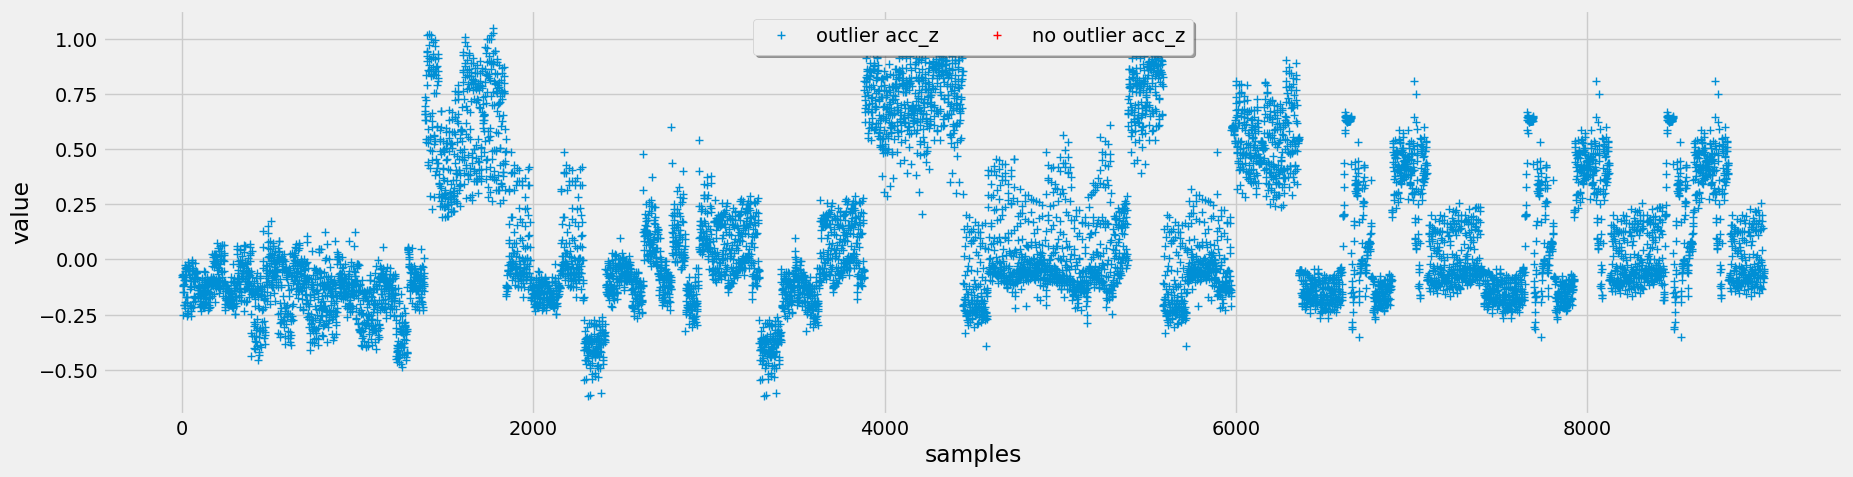

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


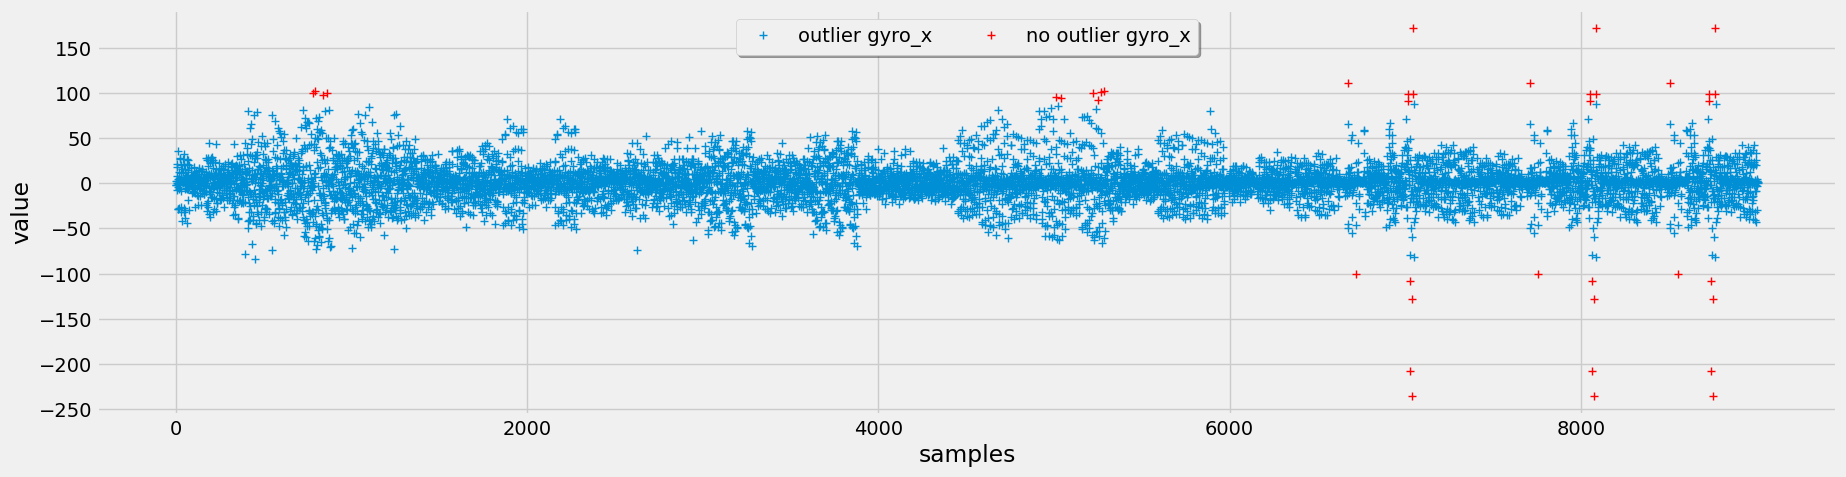

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


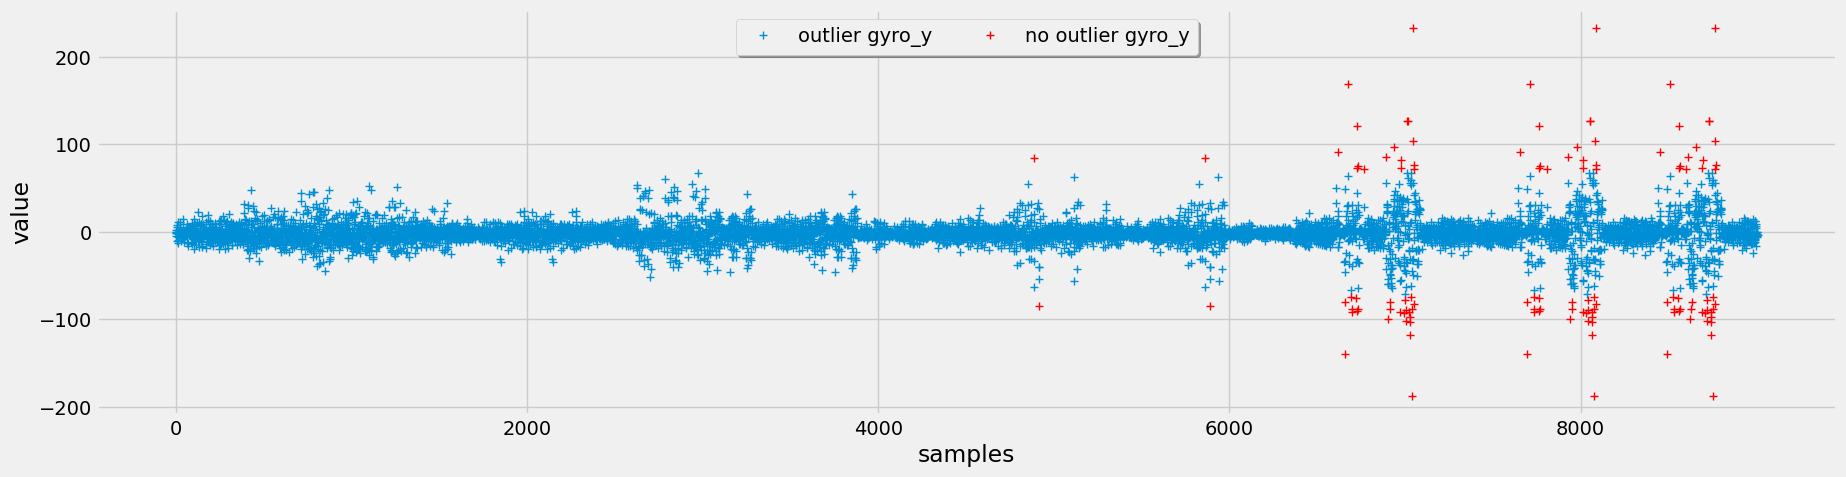

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


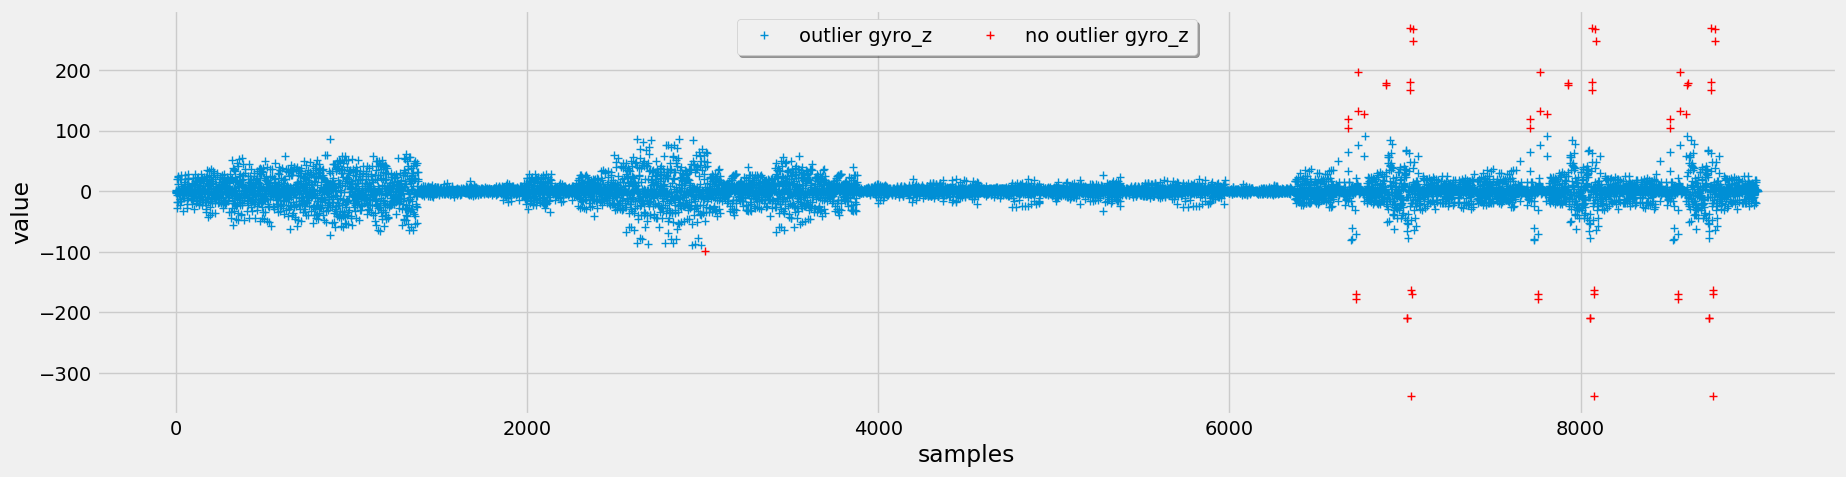

In [18]:
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(dataset = dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

### Local Outlier Factor

In [19]:
# Local outlier factor

def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores 

In [23]:
dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns)

In [24]:
dataset

acc_x     acc_y     acc_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  outlier_lof  
epoch (ms)                                                             
2019-01-11 15:08:05.200           B  bench    heavy   30        False  
2019-01-11 15:08:05.400           B  bench    heavy   30        False  
2019-01-11 15:08:05.600           B  bench    heavy   30        False  
2019-01-11 15:08:05.800           B  bench    heavy   30        False  
2019-01-11 15:08:06.000           B  bench    heavy   30        False  
...                             ...    ...      ...  ...          ...  
2019-01-20 17:33:27.000           E    row   medium   90        False  
2019-01-20 17:33:27.200           E    row   medium   90        False  
2019-01-20 17:33:27.400           E    row   medium   90        False  
2019-01-20 17:33:27.600           E    row   medium   90        False  
2019-01-20 17:33:27.800           E    row   medium   90        False  

[9009 rows x 11 columns]

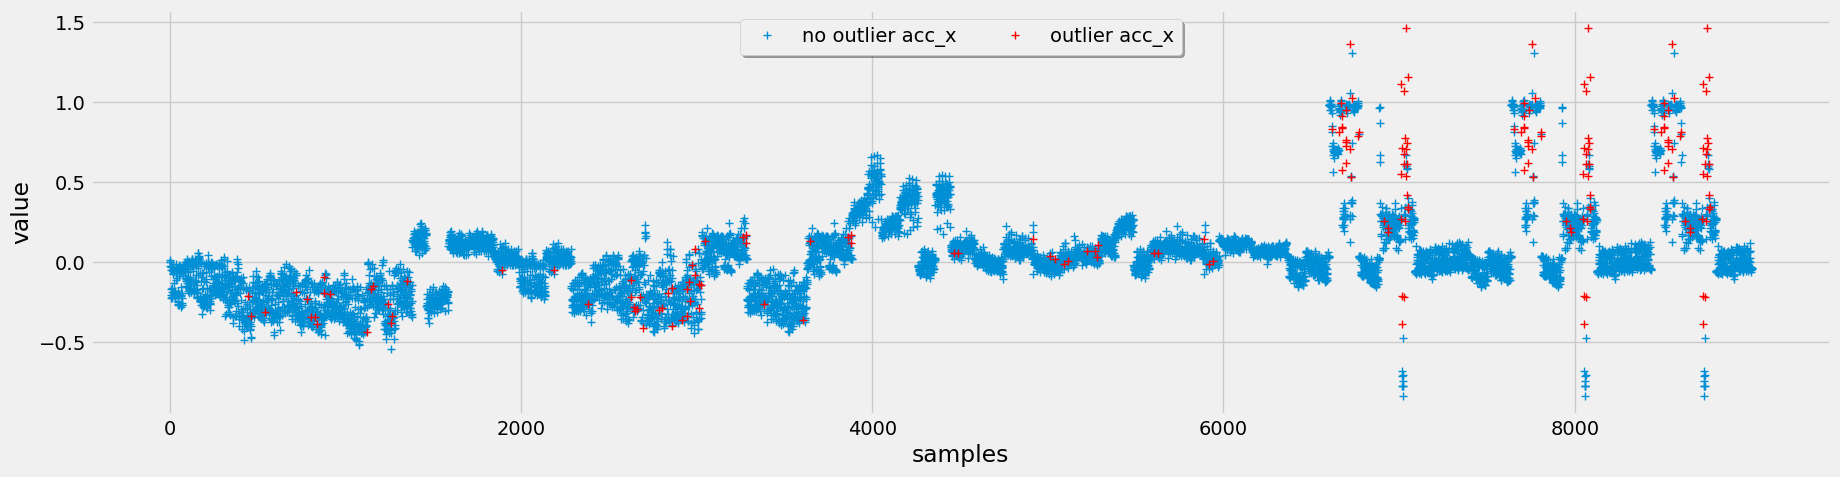

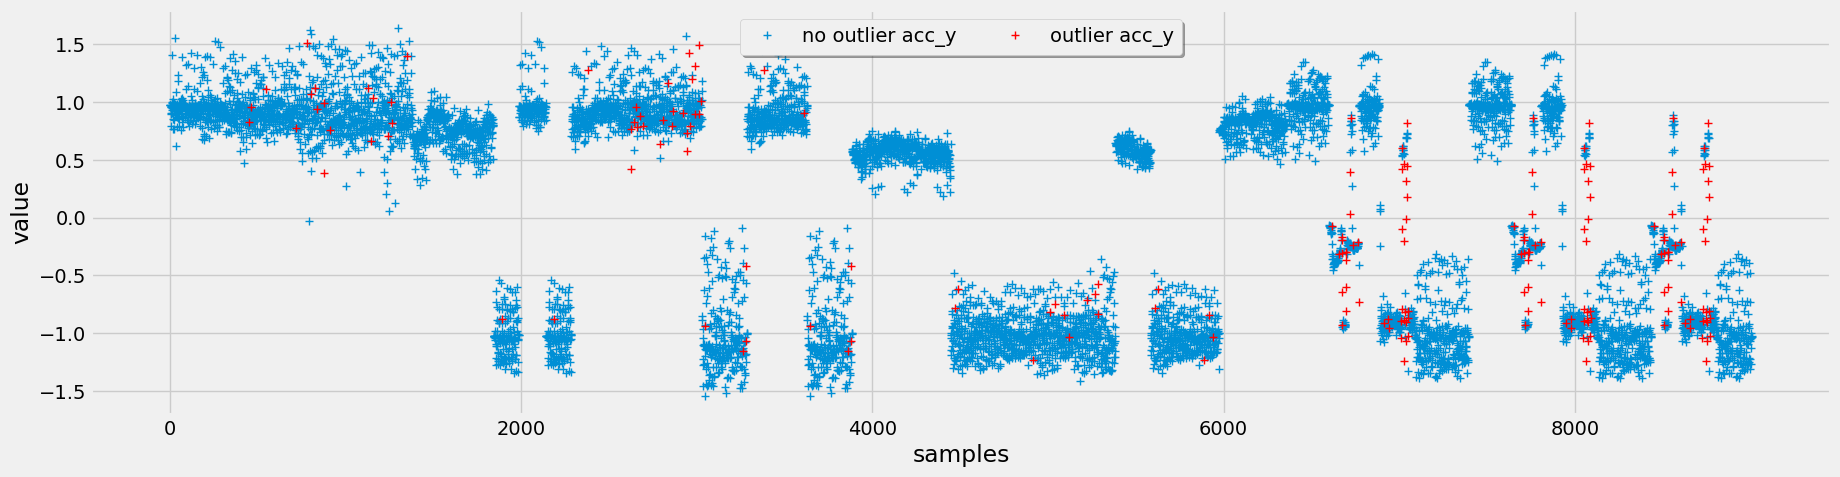

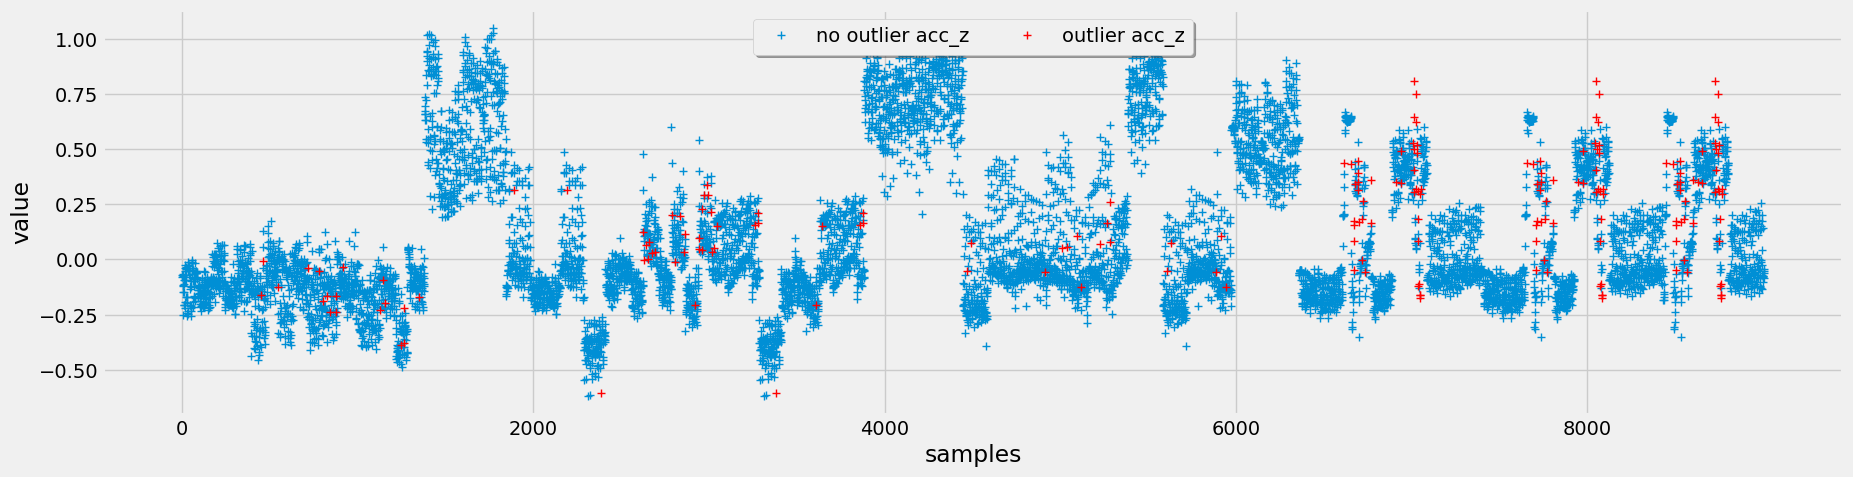

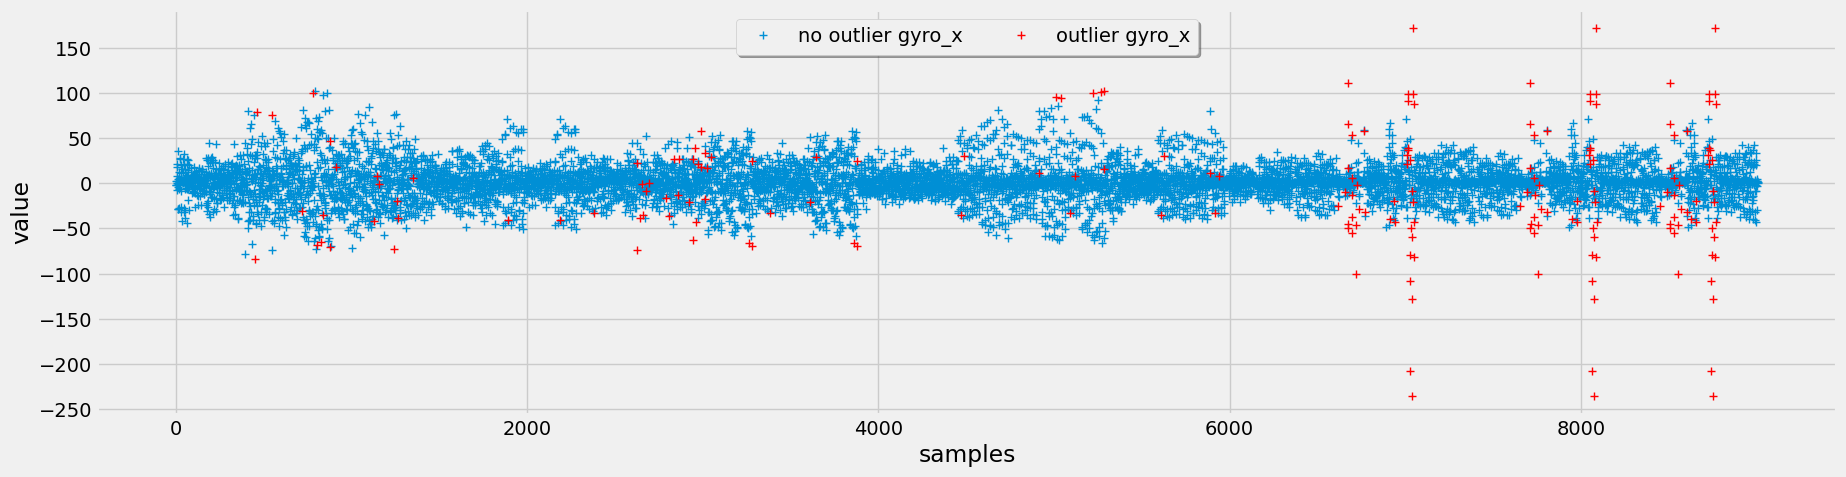

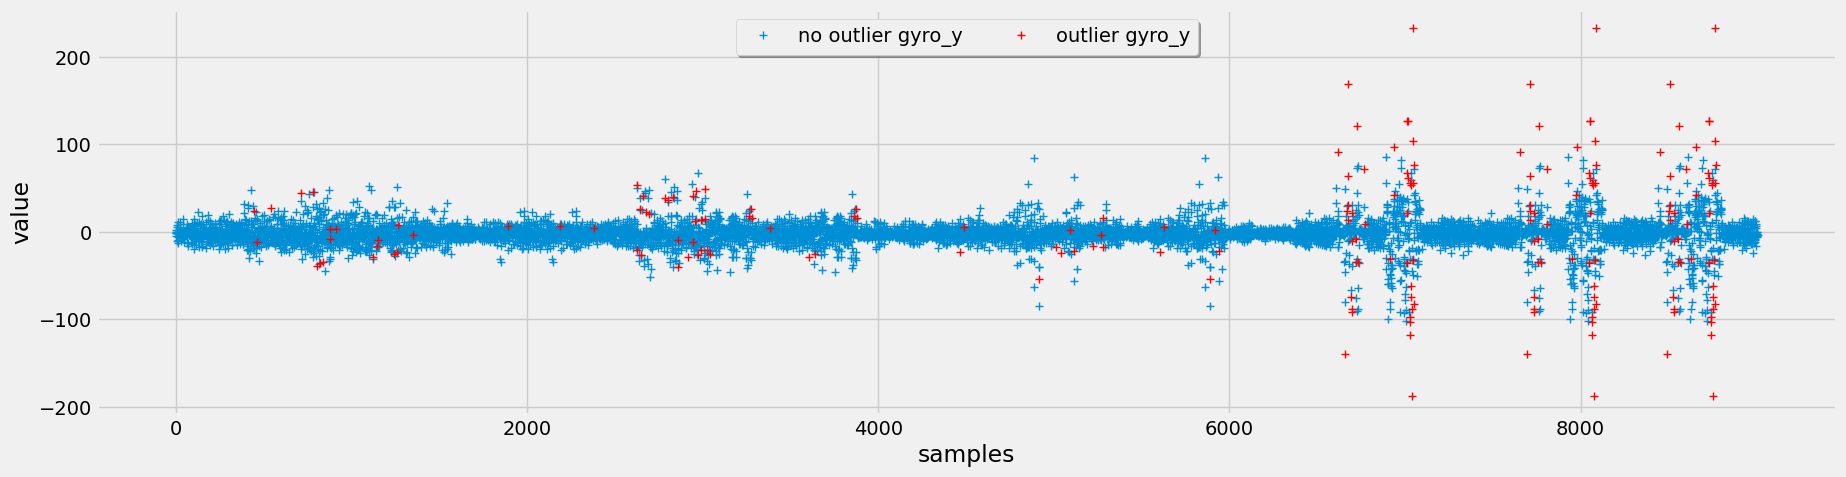

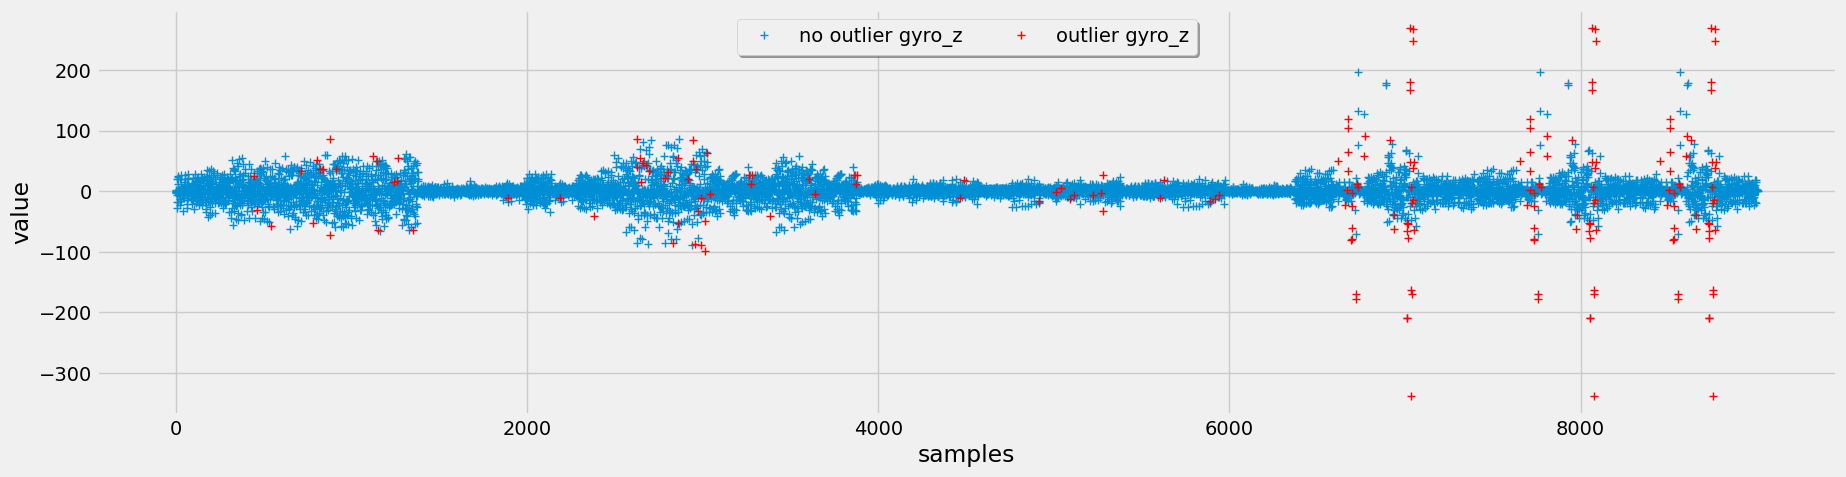

In [28]:
for col in outlier_columns:
    plot_binary_outliers(dataset = dataset, col=col, outlier_col="outlier_lof", reset_index=True)

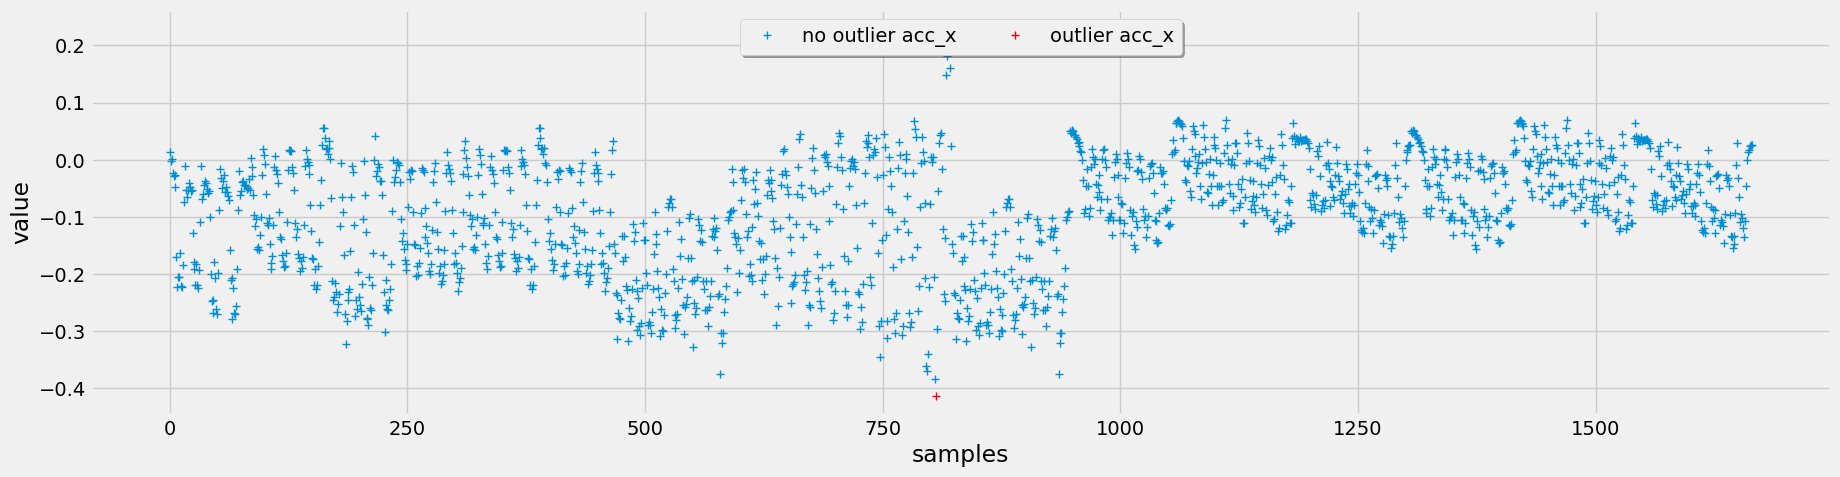

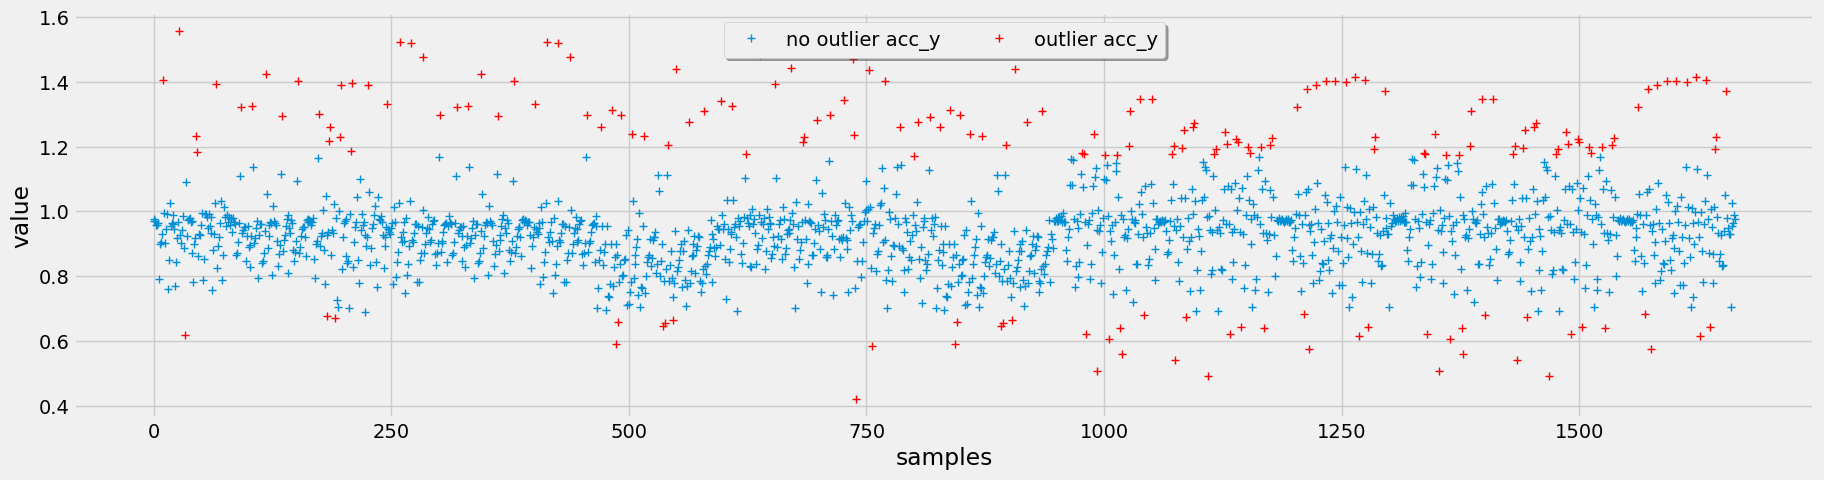

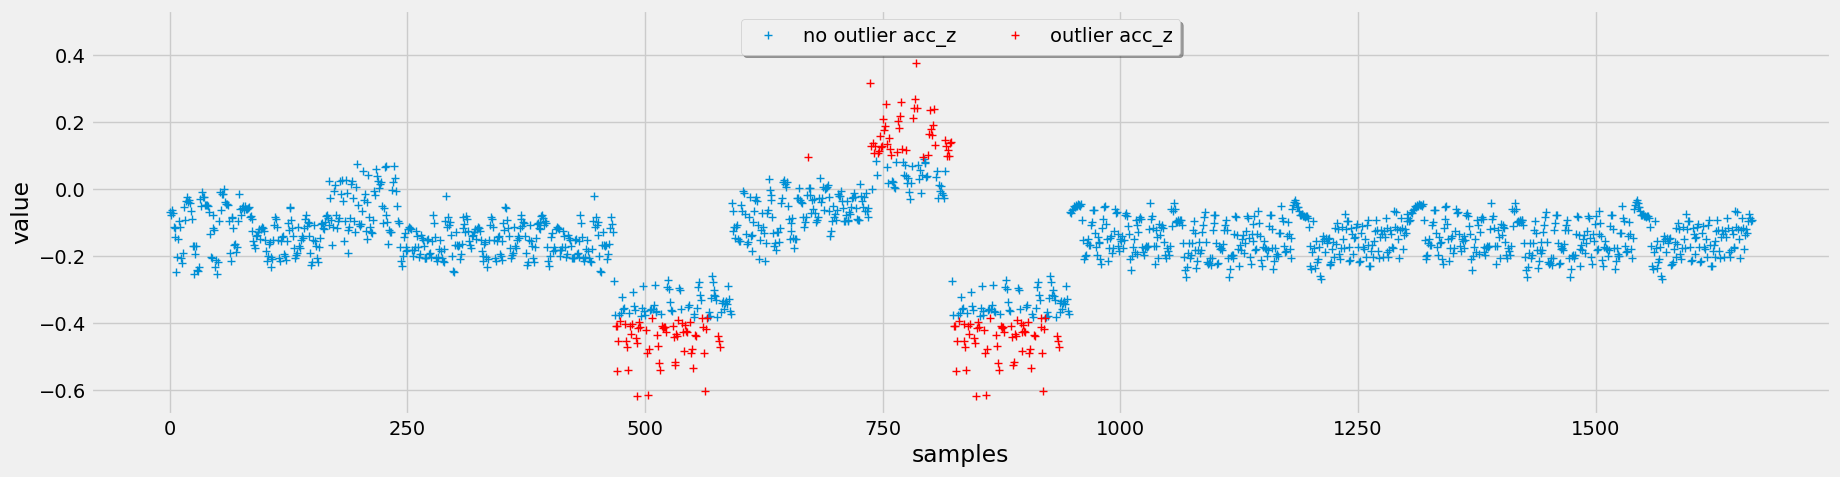

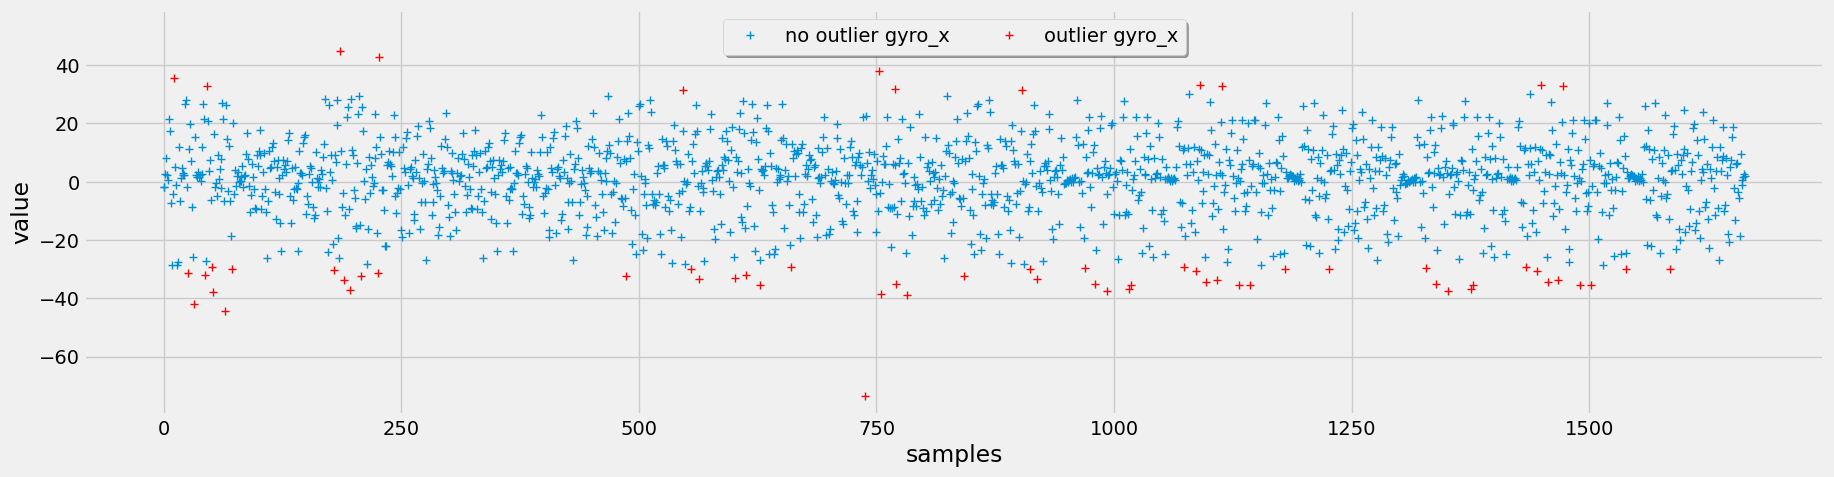

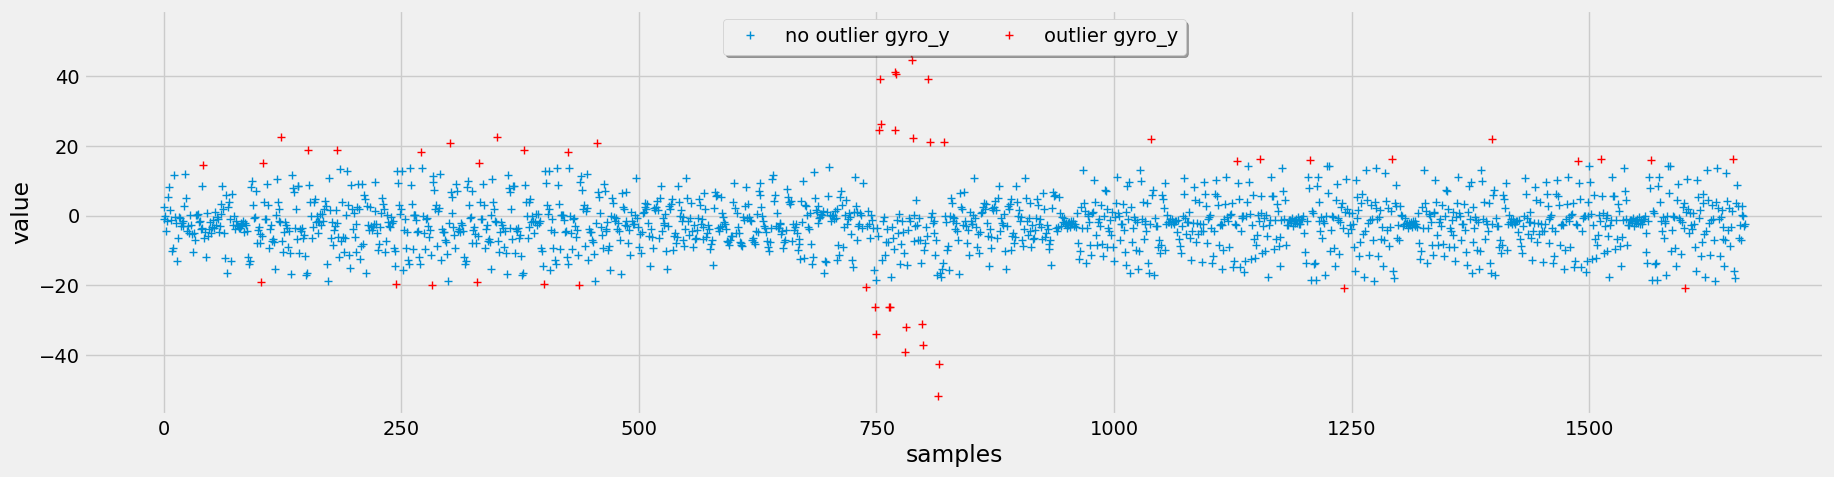

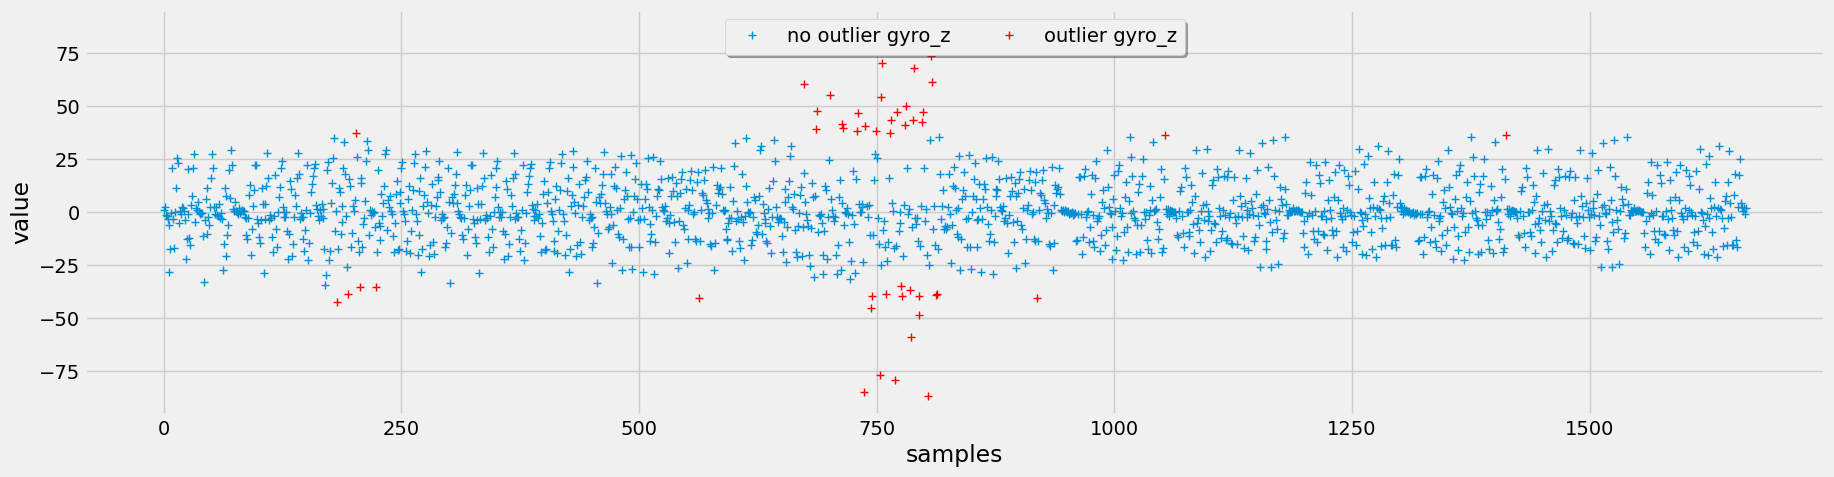

In [43]:
label = "bench"
for col in outlier_columns:
    dataset = mark_outliers_iqr(df[df["label"] == label], col)
    plot_binary_outliers(dataset, col, col+"_outlier", reset_index=True)

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


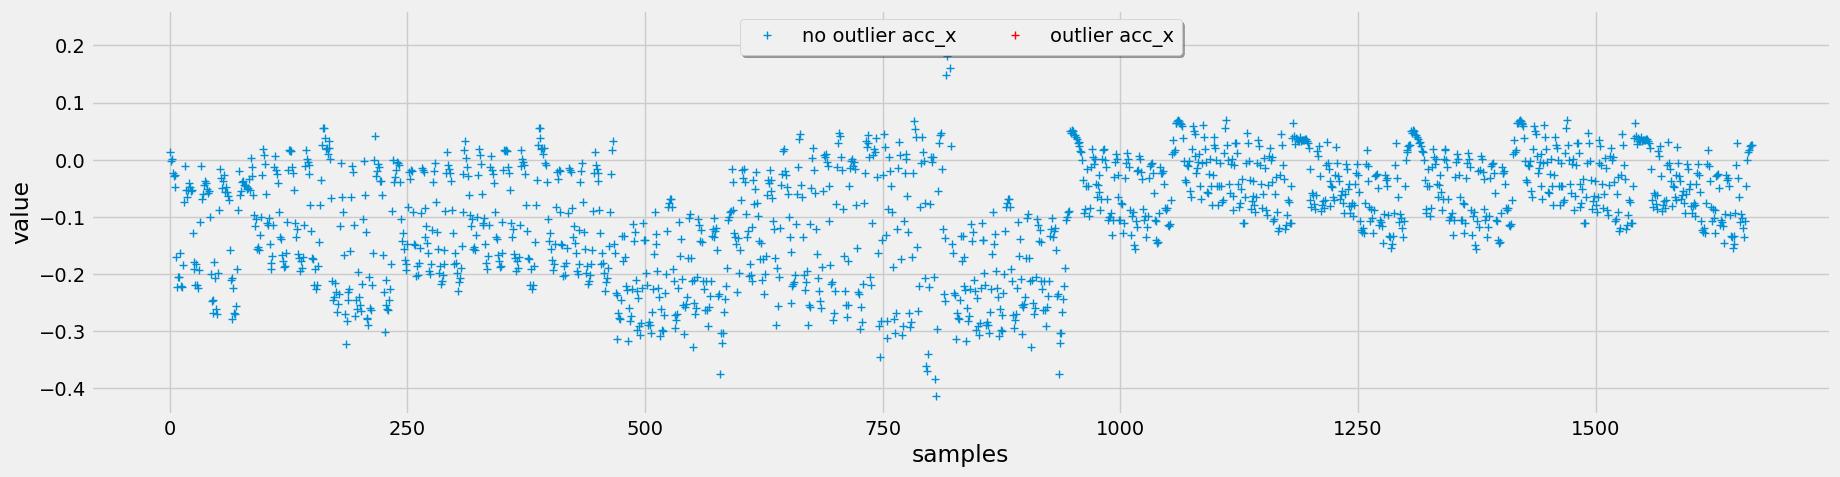

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


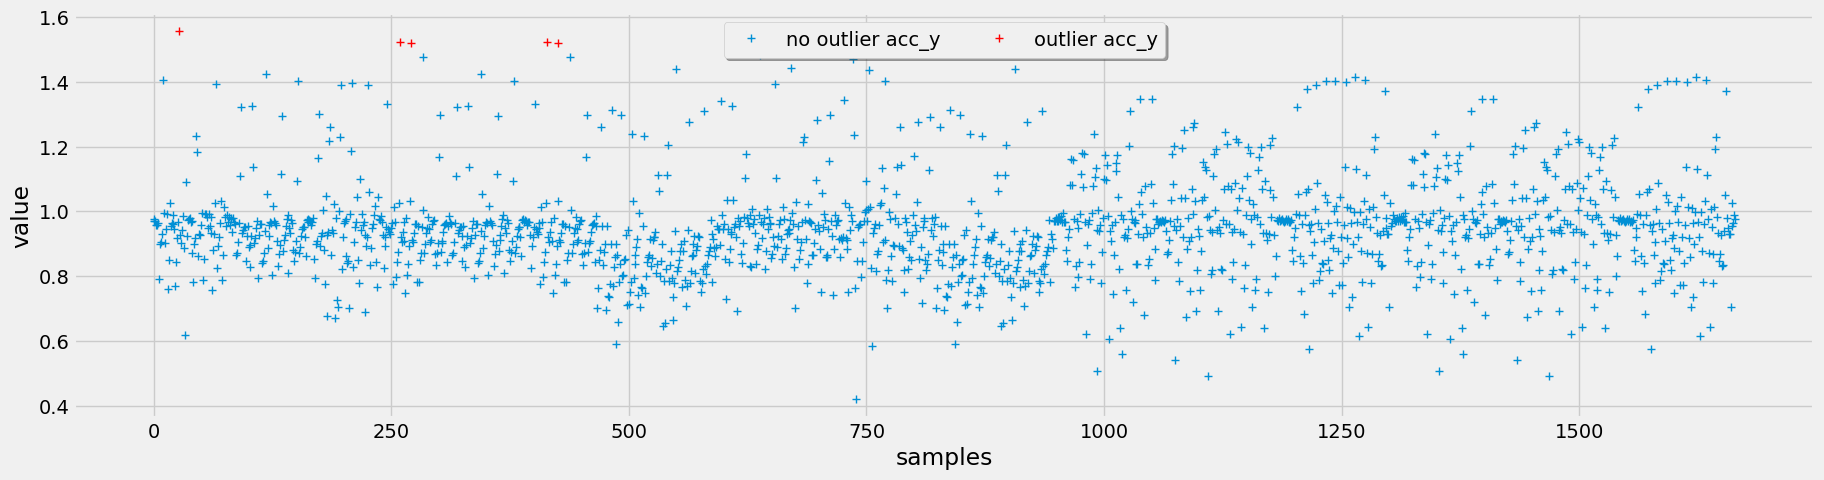

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


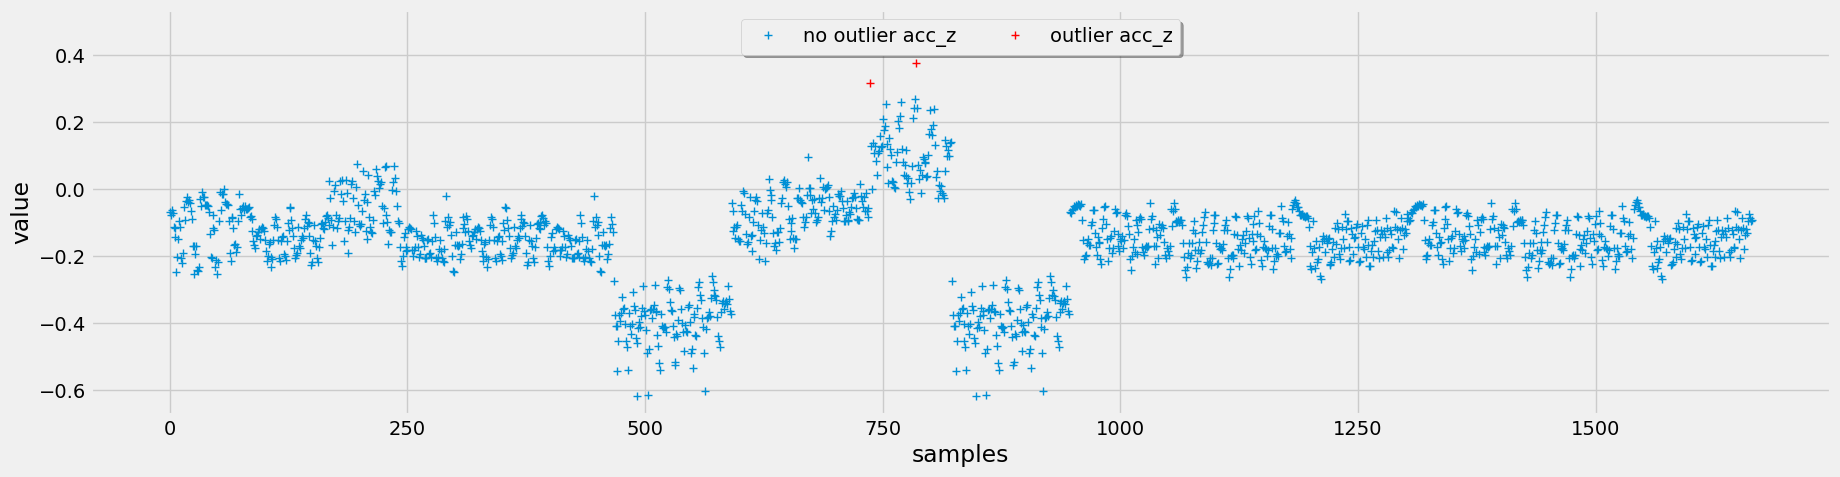

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


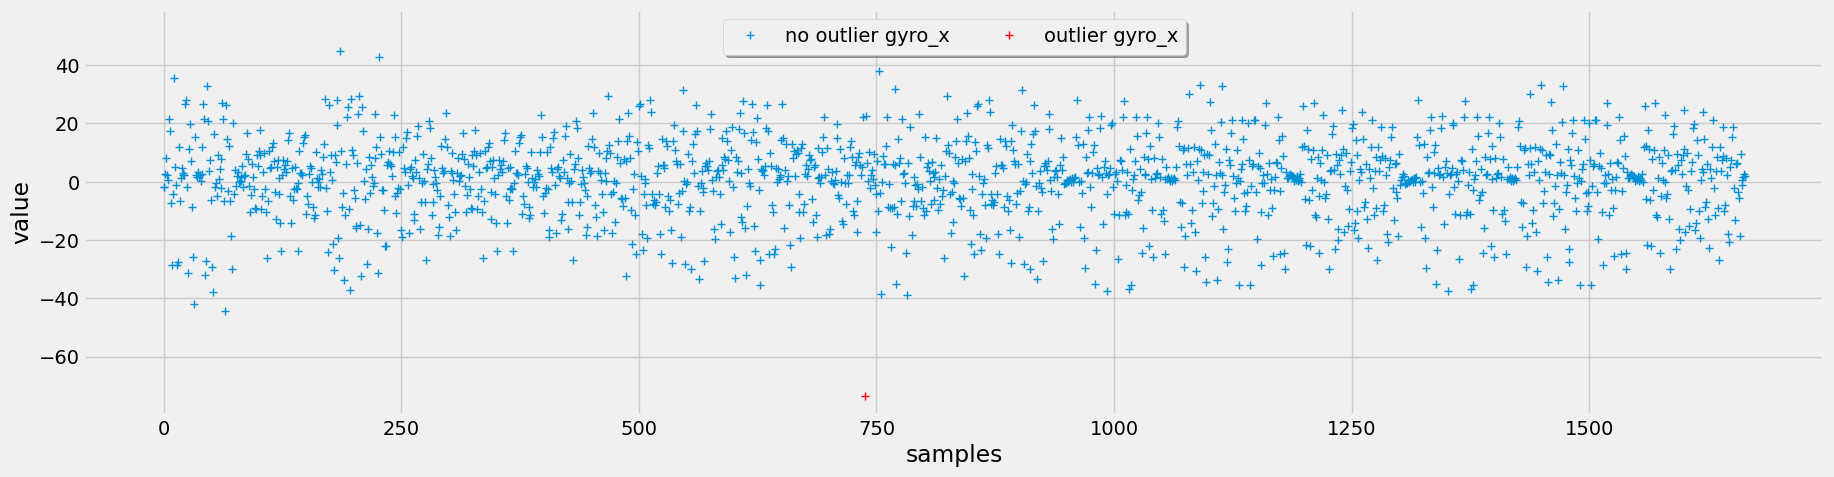

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


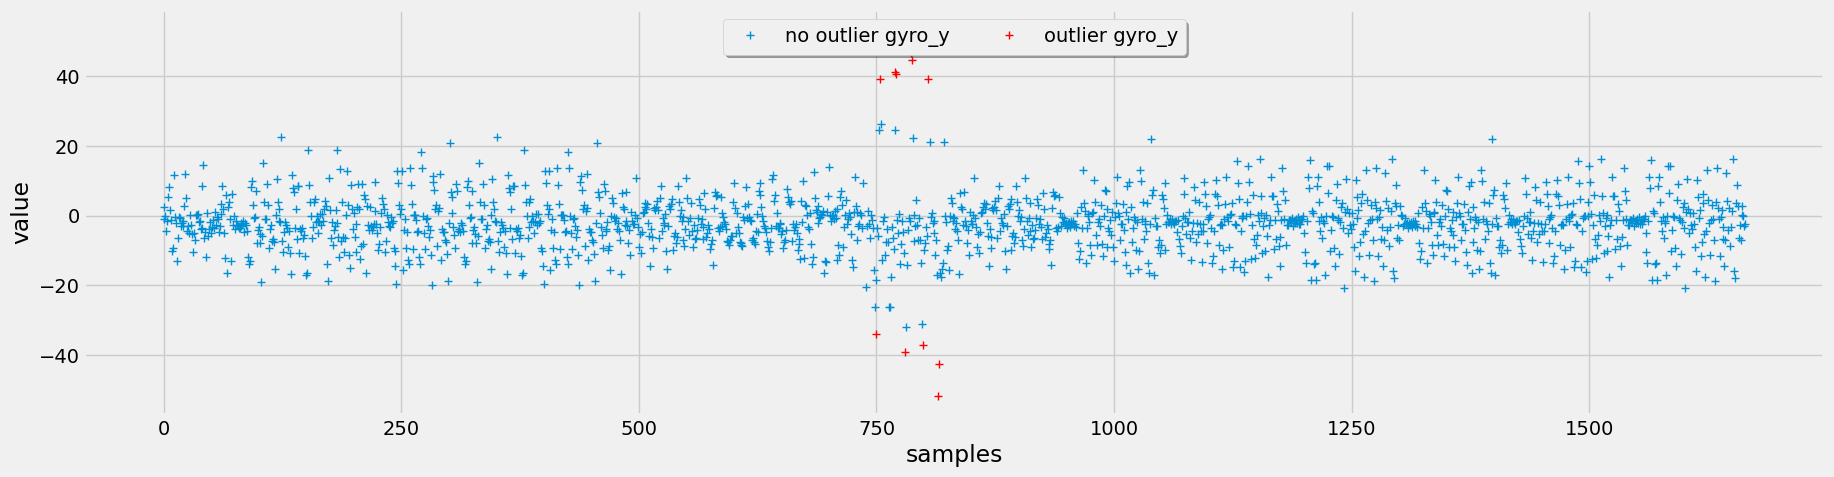

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


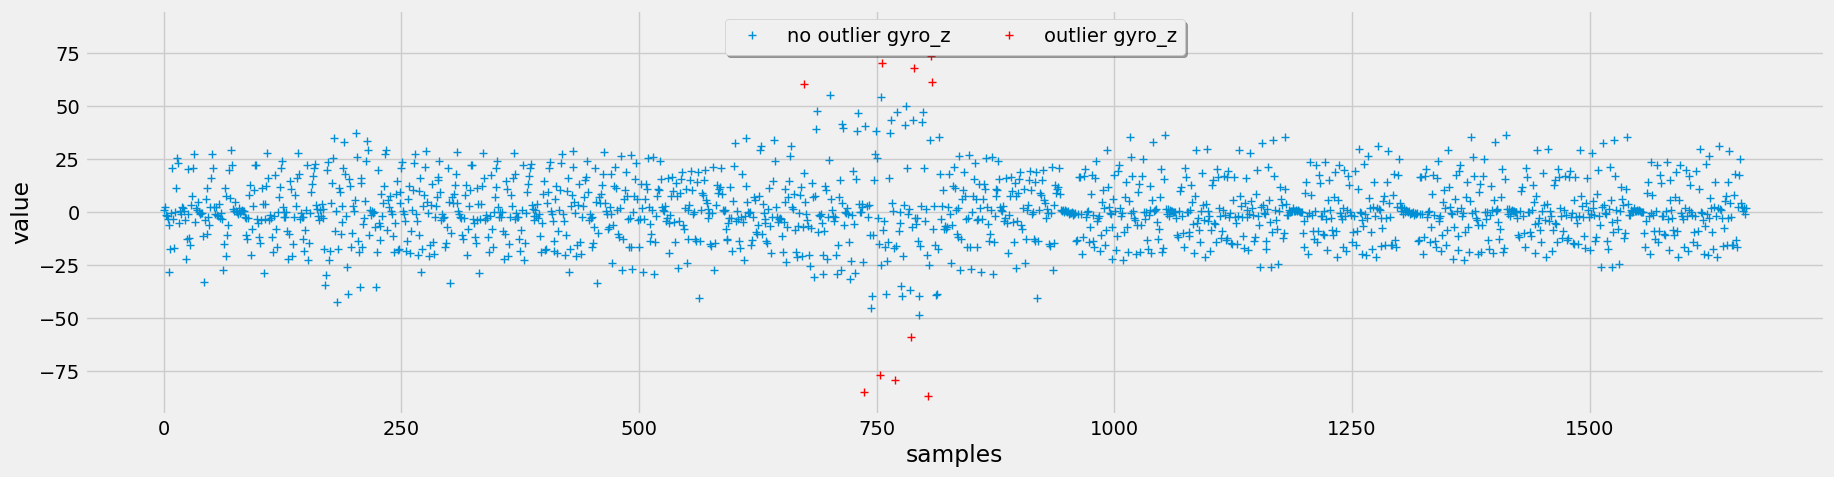

In [44]:
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df[df["label"] == label], col)
    plot_binary_outliers(dataset, col, col+"_outlier", reset_index=True)

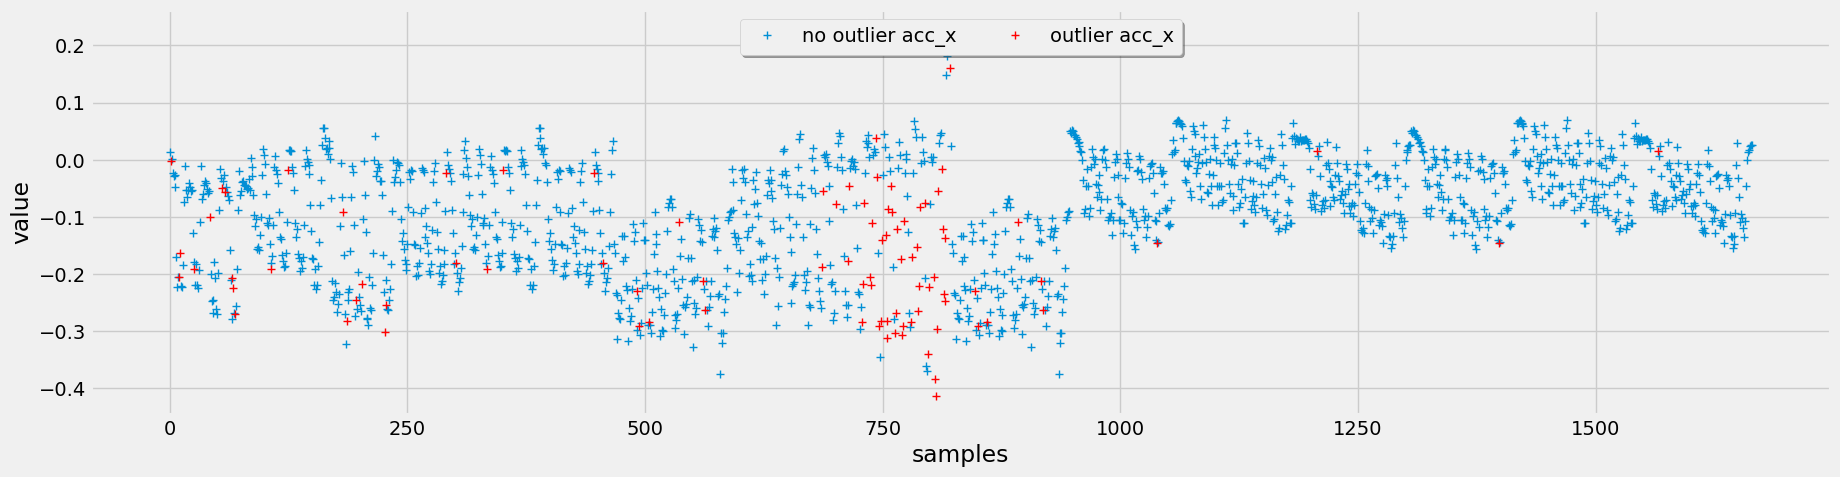

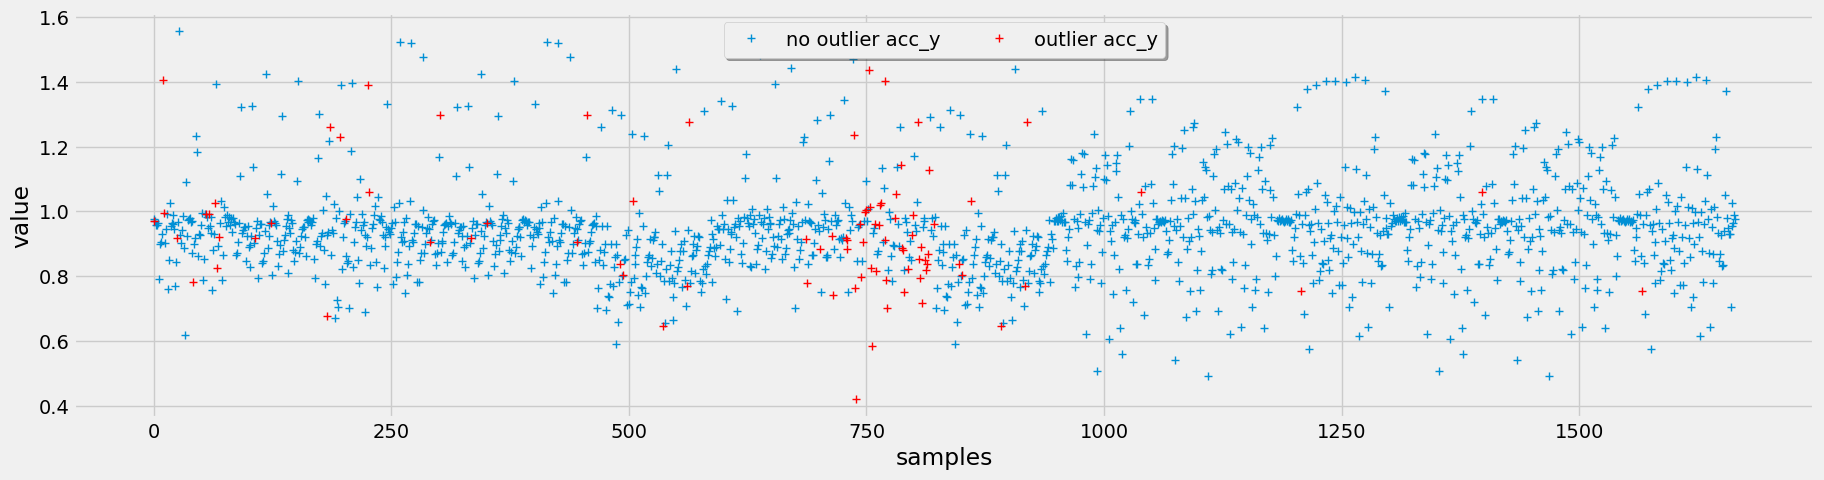

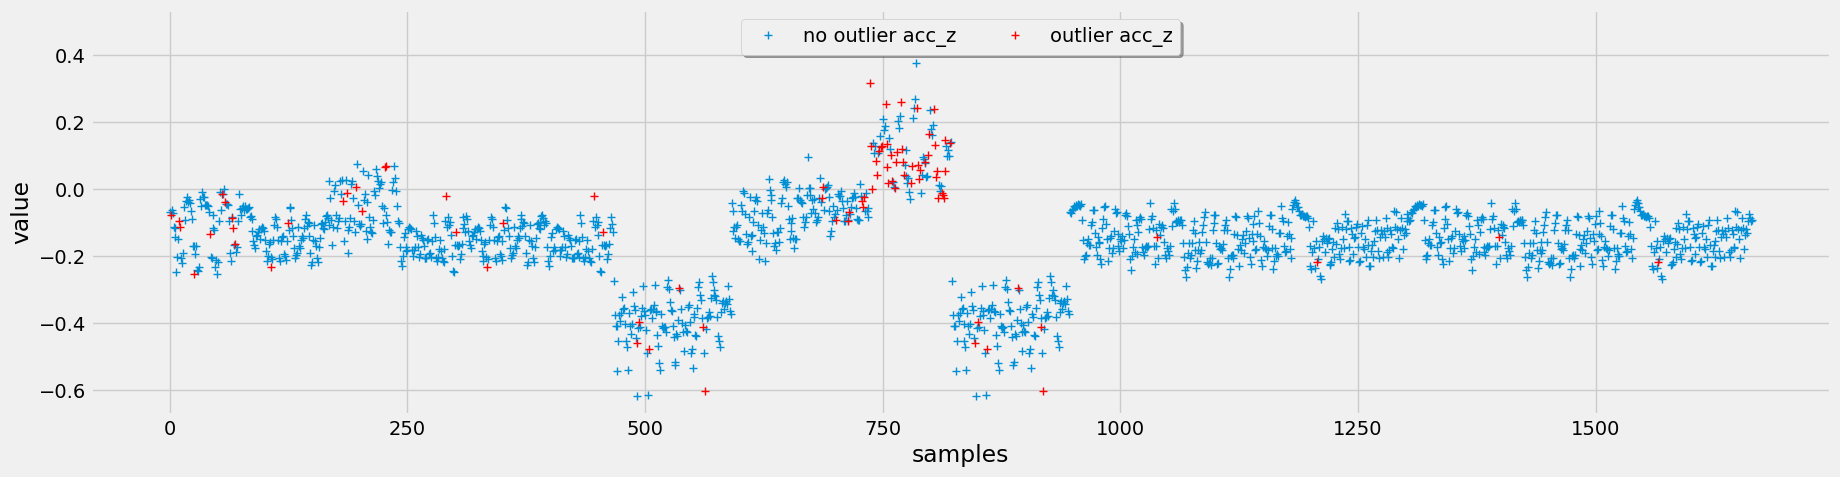

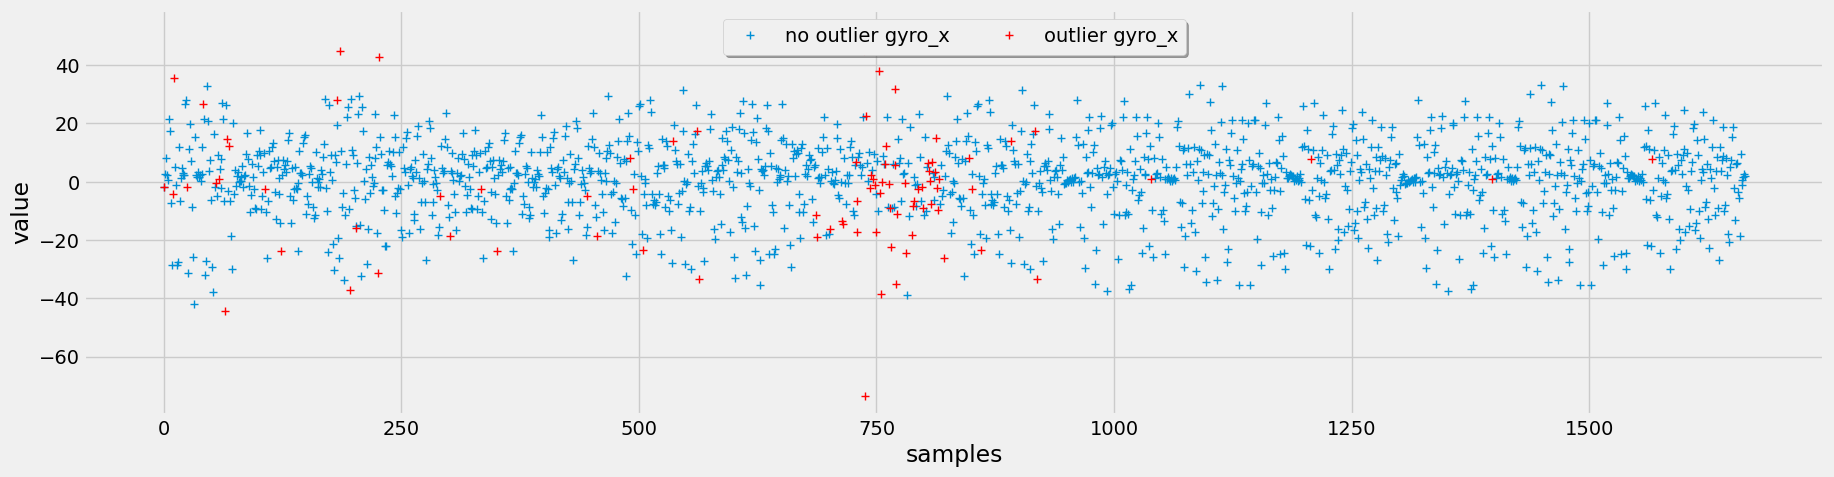

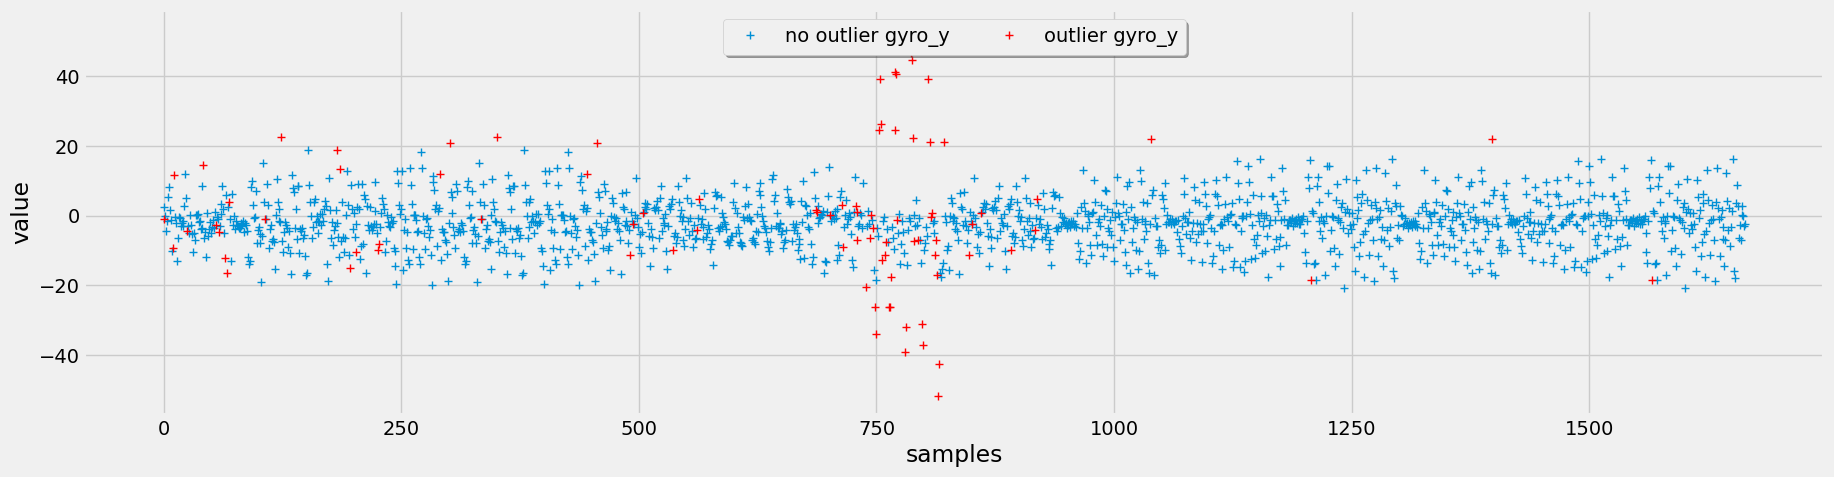

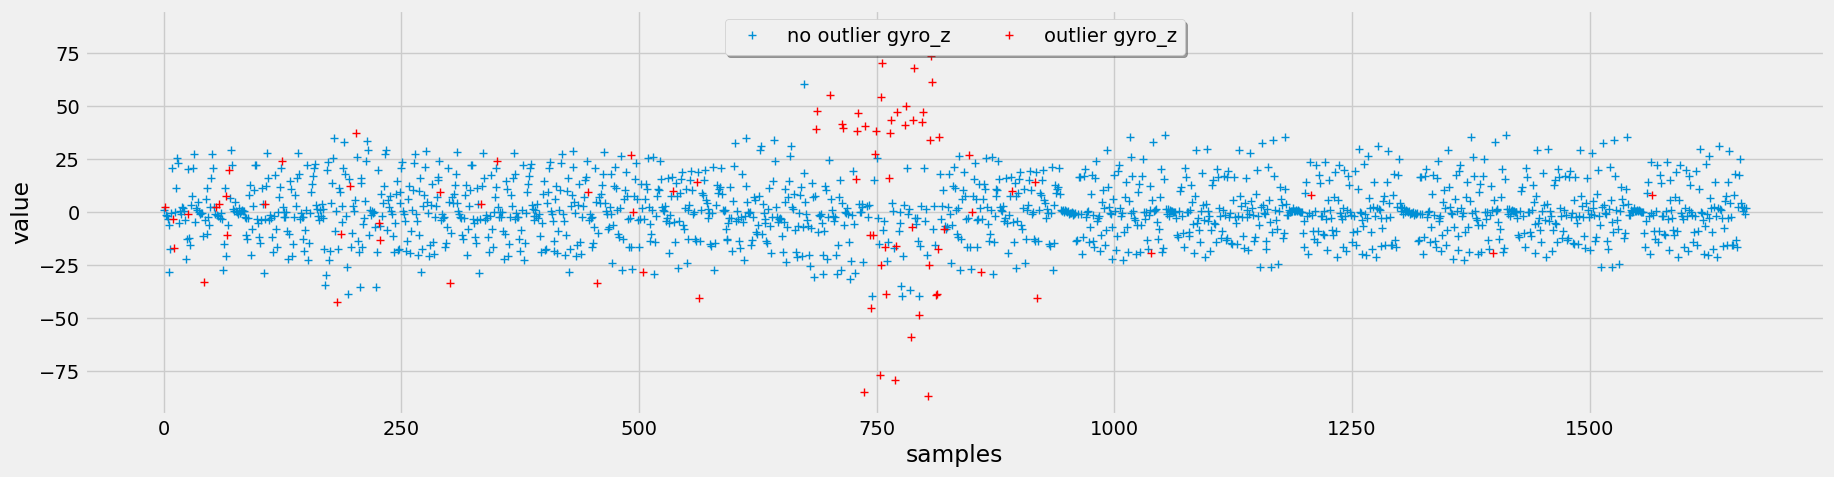

In [45]:
dataset, outliers, X_scores = mark_outliers_lof(df[df["label"] == label], outlier_columns)
for col in outlier_columns:
    plot_binary_outliers(dataset, col, outlier_col="outlier_lof", reset_index=True)

In [60]:
col = "gyro_z"
dataset = mark_outliers_chauvenet(df, col=col)


C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))


In [63]:
dataset[dataset["gyro_z_outlier"]]

acc_x     acc_y     acc_z    gyro_x    gyro_y  \
epoch (ms)                                                                  
2019-01-14 13:57:41.800 -0.137000  1.495500  0.217000   33.9146   14.6462   
2019-01-18 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-18 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-18 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-18 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-18 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-18 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-18 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-18 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-18 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-18 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-18 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-18 17:26:07.400 -0.217667  0.465667  0.320333 -108.5002 -117.7196   
2019-01-18 17:26:07.600  0.616000 -0.205500  0.625000 -207.6098  -96.8414   
2019-01-18 17:26:07.800  1.070333 -1.238333  0.751000  -79.0244 -103.5126   
2019-01-18 17:26:09.400  0.773667 -1.072000  0.310000   -8.6950  -61.7318   
2019-01-18 17:26:09.600  1.464000 -0.902000  0.083000 -128.5364  -75.0488   
2019-01-18 17:26:09.800  0.709333 -0.014667 -0.120667 -235.5244 -187.9512   
2019-01-18 17:26:11.600  0.419000  0.175500 -0.176500  171.8048  103.7316   
2019-01-18 17:26:11.800  1.155333 -0.807667 -0.160333  -81.4878  233.1832   
2019-01-19 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-19 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-19 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-19 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-19 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-19 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-19 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-19 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-19 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-19 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-19 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-19 17:26:07.400 -0.217667  0.465667  0.320333 -108.5002 -117.7196   
2019-01-19 17:26:07.600  0.616000 -0.205500  0.625000 -207.6098  -96.8414   
2019-01-19 17:26:07.800  1.070333 -1.238333  0.751000  -79.0244 -103.5126   
2019-01-19 17:26:09.400  0.773667 -1.072000  0.310000   -8.6950  -61.7318   
2019-01-19 17:26:09.600  1.464000 -0.902000  0.083000 -128.5364  -75.0488   
2019-01-19 17:26:09.800  0.709333 -0.014667 -0.120667 -235.5244 -187.9512   
2019-01-19 17:26:11.600  0.419000  0.175500 -0.176500  171.8048  103.7316   
2019-01-19 17:26:11.800  1.155333 -0.807667 -0.160333  -81.4878  233.1832   
2019-01-20 17:22:40.600  0.915500 -0.302500 -0.047500   16.5364   30.1952   
2019-01-20 17:22:40.800  0.846667 -0.645667  0.174333  -49.5610   63.7196   
2019-01-20 17:22:49.600  1.363667  0.030000 -0.001333  -45.7196   -8.1218   
2019-01-20 17:22:49.800  0.707500  0.390500  0.181500 -100.5976  -33.9634   
2019-01-20 17:22:52.000  0.371333  0.580333  0.323333   44.3416   75.4390   
2019-01-20 17:22:52.200  0.744500  0.272000  0.261500   23.2562   22.4388   
2019-01-20 17:22:59.600  0.800000 -0.406333  0.121667  -35.7436   28.3414   
2019-01-20 17:25:40.400  0.623500 -0.247500  0.226000   -5.7562   55.8294   
2019-01-20 17:25:40.600  0.669333 -0.957000  0.440667  -48.6584   85.9266   
2019-01-20 17:26:04.800  1.115000 -0.792500  0.809000   91.5732   21.1710   
2019-01-20 17:26:05.000  0.714000 -0.101000  0.646000   98.5000  127.2804   
2019-01-20 17:26:07.400 

In [62]:
dataset.loc[dataset["gyro_z_outlier"], "gyro_z"] = np.nan

In [64]:
dataset

acc_x     acc_y     acc_z  gyro_x  gyro_y  gyro_z  \
epoch (ms)                                                                      
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000 -1.8904  2.4392  0.9388   
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500 -1.6826 -0.8904  2.1708   
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  2.5608 -0.2560 -1.4146   
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  8.0610 -4.5244 -2.0730   
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  2.4390 -1.5486 -3.6098   
...                           ...       ...       ...     ...     ...     ...   
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500  1.4146 -5.6218  0.2926   
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333 -2.7684 -0.5854  2.2440   
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000  2.8416 -5.1342 -0.1220   
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667 -0.2318  0.2562  1.1220   
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000  1.0980 -4.0240  0.9760   

                        participant  label category  set  gyro_z_outlier  
epoch (ms)                                                                
2019-01-11 15:08:05.200           B  bench    heavy   30           False  
2019-01-11 15:08:05.400           B  bench    heavy   30           False  
2019-01-11 15:08:05.600           B  bench    heavy   30           False  
2019-01-11 15:08:05.800           B  bench    heavy   30           False  
2019-01-11 15:08:06.000           B  bench    heavy   30           False  
...                             ...    ...      ...  ...             ...  
2019-01-20 17:33:27.000           E    row   medium   90           False  
2019-01-20 17:33:27.200           E    row   medium   90           False  
2019-01-20 17:33:27.400           E    row   medium   90           False  
2019-01-20 17:33:27.600           E    row   medium   90           False  
2019-01-20 17:33:27.800           E    row   medium   90           False  

[9009 rows x 11 columns]

In [65]:
outliers_removed_df = df.copy()

In [69]:
for col in outlier_columns:
    for label in df["label"].unique():
        dataset = mark_outliers_chauvenet(df[df["label"] == label], col)
        
        # Replacing the values marked as outlier with NAN
        dataset.loc[dataset[col + "_outlier"], col] = np.nan
        
        # Update the column in the original dataset
        outliers_removed_df.loc[outliers_removed_df["label"] == label, col] = dataset[col]
        
        n_outliers = len(dataset) - len(dataset[col].dropna())
        
        print(f"Label: {label}, Column: {col}, Outliers removed: {n_outliers}")

C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a 

Label: bench, Column: acc_x, Outliers removed: 0
Label: ohp, Column: acc_x, Outliers removed: 2
Label: squat, Column: acc_x, Outliers removed: 0
Label: dead, Column: acc_x, Outliers removed: 2
Label: row, Column: acc_x, Outliers removed: 0
Label: rest, Column: acc_x, Outliers removed: 0
Label: bench, Column: acc_y, Outliers removed: 5
Label: ohp, Column: acc_y, Outliers removed: 6
Label: squat, Column: acc_y, Outliers removed: 0


C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a 

Label: dead, Column: acc_y, Outliers removed: 0
Label: row, Column: acc_y, Outliers removed: 0
Label: rest, Column: acc_y, Outliers removed: 0
Label: bench, Column: acc_z, Outliers removed: 3
Label: ohp, Column: acc_z, Outliers removed: 6
Label: squat, Column: acc_z, Outliers removed: 0
Label: dead, Column: acc_z, Outliers removed: 1


C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a 

Label: row, Column: acc_z, Outliers removed: 0
Label: rest, Column: acc_z, Outliers removed: 0
Label: bench, Column: gyro_x, Outliers removed: 2
Label: ohp, Column: gyro_x, Outliers removed: 4
Label: squat, Column: gyro_x, Outliers removed: 1
Label: dead, Column: gyro_x, Outliers removed: 6
Label: row, Column: gyro_x, Outliers removed: 0


C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a 

Label: rest, Column: gyro_x, Outliers removed: 12
Label: bench, Column: gyro_y, Outliers removed: 14
Label: ohp, Column: gyro_y, Outliers removed: 15
Label: squat, Column: gyro_y, Outliers removed: 9
Label: dead, Column: gyro_y, Outliers removed: 14
Label: row, Column: gyro_y, Outliers removed: 10
Label: rest, Column: gyro_y, Outliers removed: 9
Label: bench, Column: gyro_z, Outliers removed: 13
Label: ohp, Column: gyro_z, Outliers removed: 1
Label: squat, Column: gyro_z, Outliers removed: 12
Label: dead, Column: gyro_z, Outliers removed: 14
Label: row, Column: gyro_z, Outliers removed: 0
Label: rest, Column: gyro_z, Outliers removed: 24


C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
C:\Users\91780\AppData\Local\Temp\ipykernel_3864\3349480482.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a 

In [71]:
outliers_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyro_x       8984 non-null   float64
 4   gyro_y       8938 non-null   float64
 5   gyro_z       8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


In [72]:
outliers_removed_df.to_pickle("../data/interim/02_outliers_removed_chauvenets.pkl")